[INFO] Rows for selected IDs: 140
[INFO] IDs present: ['10038001', '10038002', '10038003', '10038004', '10038005']

[DIAG] Per-ID local time span on 2025-09-03
                               min                       max
ID                                                          
10038001 2025-09-03 02:05:00+02:00 2025-09-03 06:50:00+02:00
10038002 2025-09-03 02:05:00+02:00 2025-09-03 06:50:00+02:00
10038003 2025-09-03 02:05:00+02:00 2025-09-03 06:50:00+02:00
10038004 2025-09-03 02:05:00+02:00 2025-09-03 06:50:00+02:00
10038005 2025-09-03 02:05:00+02:00 2025-09-03 06:50:00+02:00

[WARN] No points in 07:30–19:30; using full available span for the day.

[INFO] Saved CSV: traffic_5sensors_total_5min_2025-09-03.csv
[INFO] Plot span: 2025-09-03 02:05:00+02:00 → 2025-09-03 06:50:00+02:00


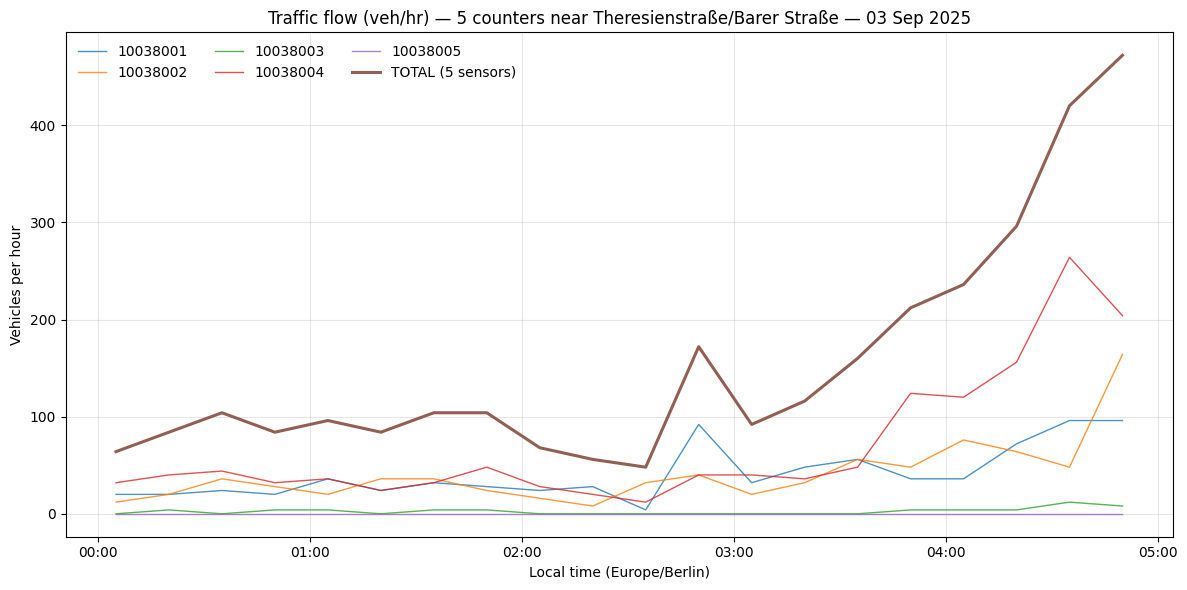

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

# ----------------------------
# CONFIG
# ----------------------------
traffic_file = "2025-9-3_TrafficFlow.txt"
sensor_ids   = ["10038001","10038002","10038003","10038004","10038005"]
day_local    = "2025-09-03"
win_start    = pd.Timestamp(f"{day_local} 07:30", tz="Europe/Berlin")
win_end      = pd.Timestamp(f"{day_local} 19:30", tz="Europe/Berlin")
resample_grid = "5min"

# ----------------------------
# LOAD + SOFT COLUMN MATCH
# ----------------------------
raw = pd.read_csv(traffic_file, on_bad_lines="skip", low_memory=False, dtype=str)

def find_col(df, candidates):
    for pat in candidates:
        for c in df.columns:
            if re.fullmatch(pat, c, flags=re.IGNORECASE):
                return c
    return None

col_id  = find_col(raw, [r"ID", r"id", r".*identifier.*"])
col_dt  = find_col(raw, [r"DateTime", r"datetime", r".*Date.*Time.*", r".*time.*"])
col_flow= find_col(raw, [r".*vehicleFlowRate", r"vehicleFlowRate", r"flow", r"count"])
col_per = find_col(raw, [r".*measurementOrCalculationPeriod", r"period", r".*period.*"])

if not (col_id and col_dt and col_flow):
    raise RuntimeError(f"Missing essential columns. Found: ID={col_id}, DateTime={col_dt}, flow={col_flow}")

df = raw[[col_id, col_dt, col_flow] + ([col_per] if col_per else [])].copy()

# Clean IDs (strip, drop trailing .0, keep digits)
df[col_id] = (df[col_id].astype(str).str.strip()
                         .str.replace(r"\.0$", "", regex=True)
                         .str.extract(r"(\d+)", expand=False))
df = df.dropna(subset=[col_id])

# Flow numeric; default period 900 s if missing/invalid
df[col_flow] = pd.to_numeric(df[col_flow], errors="coerce")
if col_per:
    df[col_per] = pd.to_numeric(df[col_per], errors="coerce").fillna(900.0)
else:
    df[col_per] = 900.0

# Parse timestamps; your strings already have +02:00 → tz-aware
df[col_dt] = pd.to_datetime(df[col_dt], errors="coerce")
df = df.dropna(subset=[col_dt])

# Make sure we’re in Europe/Berlin (if aware → tz_convert, if naive → tz_localize)
if df[col_dt].dt.tz is None:
    df[col_dt] = df[col_dt].dt.tz_localize("Europe/Berlin")
else:
    df[col_dt] = df[col_dt].dt.tz_convert("Europe/Berlin")

# Filter to the five sensors
df = df[df[col_id].isin(sensor_ids)].copy()
print("[INFO] Rows for selected IDs:", len(df))
print("[INFO] IDs present:", sorted(df[col_id].unique().tolist()))

# Quick per-ID min/max to see what’s actually there on that day
day_mask = df[col_dt].dt.date == pd.Timestamp(day_local).date()
per_id_span = (df[day_mask]
               .groupby(col_id)[col_dt]
               .agg(['min','max'])
               .sort_index())
print("\n[DIAG] Per-ID local time span on", day_local)
print(per_id_span)

# Restrict to the requested window; if empty, fall back to actual day span
sub = df[day_mask & (df[col_dt] >= win_start) & (df[col_dt] <= win_end)].copy()
if sub.empty:
    print("\n[WARN] No points in 07:30–19:30; using full available span for the day.")
    sub = df[day_mask].copy()
    # If still empty, abort with info
    if sub.empty:
        raise SystemExit("No rows for these sensors on this day.")

# Convert to veh/hr from the 15-min counts
period = sub[col_per].replace(0, 900.0)
sub["veh_per_hr"] = sub[col_flow] * (3600.0 / period)

# Resample to a regular 5-min grid per sensor (time interpolation for small gaps)
sub = sub.set_index(col_dt).sort_index()
time_index = pd.date_range(sub.index.min().floor(resample_grid),
                           sub.index.max().ceil(resample_grid),
                           freq=resample_grid, tz="Europe/Berlin")

wide = pd.DataFrame(index=time_index)
for sid in sensor_ids:
    s = (sub[sub[col_id]==sid]["veh_per_hr"]
         .reindex(time_index)
         .interpolate(method="time", limit=3))  # fill ≤15min gaps
    wide[sid] = s

wide["TOTAL"] = wide[sensor_ids].sum(axis=1)

# If we *did* find points in the original 07:30–19:30, clip to that for the plot
if (df[day_mask & (df[col_dt] >= win_start) & (df[col_dt] <= win_end)].empty) is False:
    wide = wide[(wide.index >= win_start) & (wide.index <= win_end)]

# Save tidy CSV
wide.index.name = "DateTime_local"
wide.to_csv("traffic_5sensors_total_5min_2025-09-03.csv")
print("\n[INFO] Saved CSV: traffic_5sensors_total_5min_2025-09-03.csv")
print("[INFO] Plot span:", wide.index.min(), "→", wide.index.max())

# Plot
plt.figure(figsize=(12,6))
for sid in sensor_ids:
    plt.plot(wide.index, wide[sid], linewidth=1.0, alpha=0.8, label=sid)
plt.plot(wide.index, wide["TOTAL"], linewidth=2.2, alpha=0.95, label="TOTAL (5 sensors)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Traffic flow (veh/hr) — 5 counters near Theresienstraße/Barer Straße — 03 Sep 2025")
plt.xlabel("Local time (Europe/Berlin)")
plt.ylabel("Vehicles per hour")
plt.grid(True, alpha=0.3)
plt.legend(ncol=3, frameon=False)
plt.tight_layout()
plt.show()

In [44]:
import pandas as pd
import re

traffic_file = "2025-9-3_TrafficFlow.txt"
day_local = "2025-09-03"

# --- Load raw ---
raw = pd.read_csv(traffic_file, on_bad_lines="skip", low_memory=False, dtype=str)

sensor_ids = ["10038001","10038002","10038003","10038004","10038005"]

# Filter raw data for the 5 sensors and the requested day
mask = (raw["ID"].isin(sensor_ids)) & (raw["DateTime"].str.startswith(day_local))
traffic_day = raw.loc[mask]

print(traffic_day)

       @index measuredValue.basicData.@xsi:type  \
512        10                       TrafficFlow   
513        10                       TrafficFlow   
514        10                       TrafficFlow   
515        10                       TrafficFlow   
516        10                       TrafficFlow   
...       ...                               ...   
189677     10                       TrafficFlow   
189678     10                       TrafficFlow   
189679     10                       TrafficFlow   
189680     10                       TrafficFlow   
189681     10                       TrafficFlow   

       measuredValue.basicData.measurementOrCalculationPeriod  \
512                                                 900.0       
513                                                 900.0       
514                                                 900.0       
515                                                 900.0       
516                                                 900.0     

[INFO] Rows for five sensors on 2025-09-03: 100
[SAVE] traffic_5sensors_whole_day_2025-09-03.csv


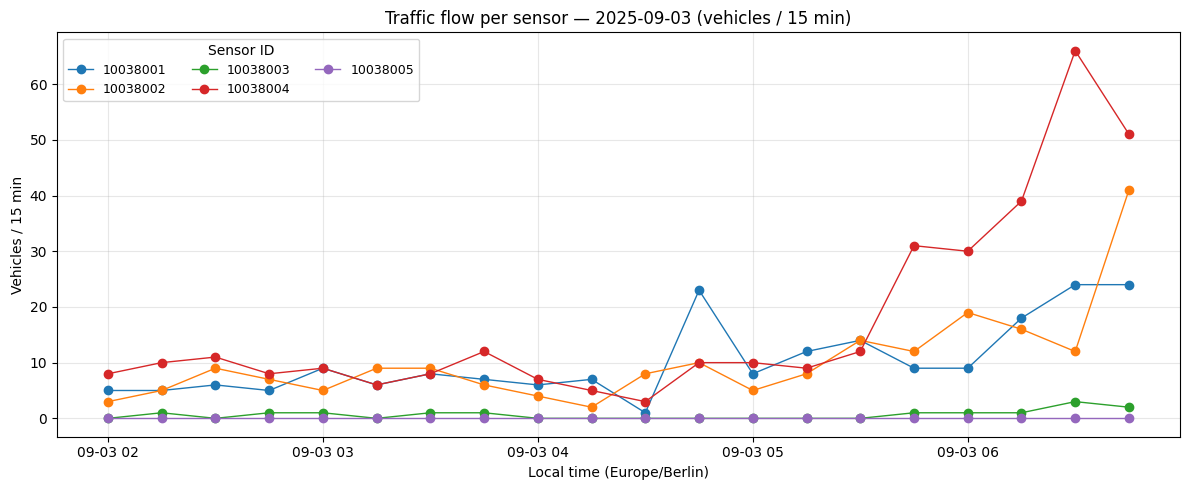

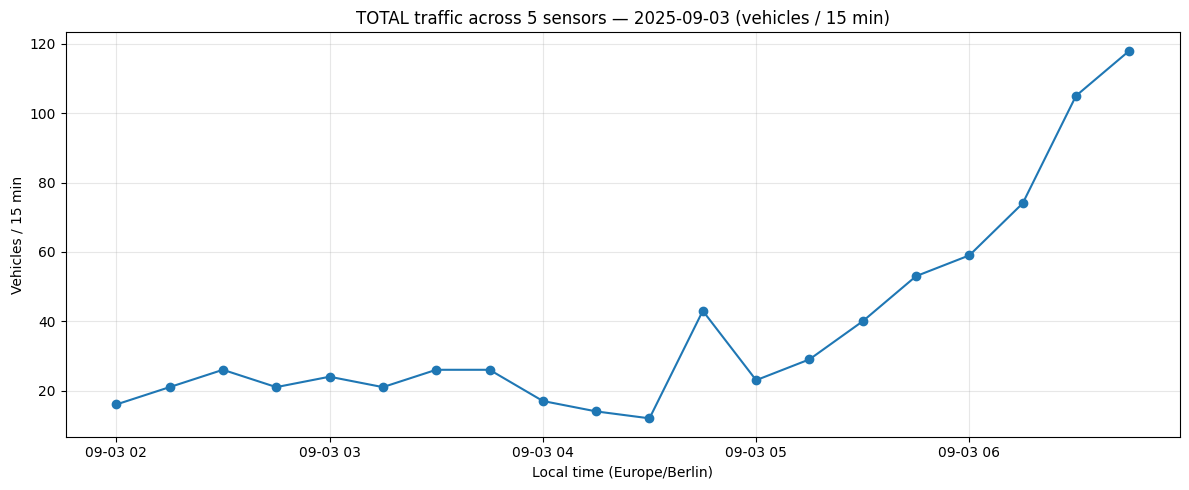

[SAVE] traffic_5sensors_hourly_2025-09-03.csv


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

traffic_file = "2025-9-3_TrafficFlow.txt"
target_ids   = {"10038001","10038002","10038003","10038004","10038005"}
LOCAL_TZ     = "Europe/Berlin"
TARGET_DATE  = pd.Timestamp("2025-09-03").date()   # whole local day

# ---------- load flexibly ----------
df = pd.read_csv(traffic_file, on_bad_lines="skip", low_memory=False, dtype=str)

def identify_columns(df):
    cols = df.columns.tolist()
    # If a DateTime-like header exists, use headers
    if any("datetime" in c.lower() for c in cols):
        # DateTime
        dt_col = [c for c in cols if "datetime" in c.lower()][0]
        # ID
        id_candidates = [c for c in cols if c.lower() == "id"] or [c for c in cols if "identifier" in c.lower()]
        id_col = id_candidates[0] if id_candidates else "ID"
        # flow
        flow_col = None
        for c in cols:
            cl = c.lower()
            if "vehicleflowrate" in cl or cl.endswith("flow") or "flowrate" in cl:
                flow_col = c; break
        return dt_col, id_col, flow_col
    # No headers we recognize → assign by width
    if df.shape[1] == 7:
        df.columns = ["idx","type","period","vehType","flow","DateTime","ID"]
        return "DateTime","ID","flow"
    if df.shape[1] == 8:
        df.columns = ["idx","type","period","vehType","flow","occupancy","DateTime","ID"]
        return "DateTime","ID","flow"
    # Fallback guess: last two are DateTime, ID; pick first numeric-like as flow
    dt_guess, id_guess = cols[-2], cols[-1]
    flow_guess = None
    for c in cols:
        if c not in (dt_guess, id_guess):
            try:
                pd.to_numeric(df[c])
                flow_guess = c; break
            except Exception:
                pass
    return dt_guess, id_guess, flow_guess

dt_col, id_col, flow_col = identify_columns(df)
if flow_col is None:
    raise RuntimeError("Couldn't identify the flow column. Inspect headers and set it explicitly.")

# ---------- clean types ----------
df = df[[dt_col, id_col, flow_col]].copy()

# Normalize ID: strip, drop '.0', keep digits only
df[id_col] = (df[id_col].str.strip()
                        .str.replace(r"\.0$", "", regex=True)
                        .str.extract(r"(\d+)", expand=False))

# Flow to numeric
df[flow_col] = pd.to_numeric(df[flow_col], errors="coerce")

# Parse DateTime (strings include +02:00 → tz-aware)
df["DateTime"] = pd.to_datetime(df[dt_col], errors="coerce")
# If any rows are tz-naive, localize to Europe/Berlin
if df["DateTime"].dt.tz is None:
    df["DateTime"] = df["DateTime"].dt.tz_localize(LOCAL_TZ)

# ---------- filter to target sensors & target date (whole day), no hour window ----------
sub = df[df[id_col].isin(target_ids)].dropna(subset=["DateTime", flow_col]).copy()
sub["LocalTime"] = sub["DateTime"].dt.tz_convert(LOCAL_TZ)
sub = sub[sub["LocalTime"].dt.date == TARGET_DATE]

print(f"[INFO] Rows for five sensors on {TARGET_DATE}: {len(sub)}")
if sub.empty:
    print("[WARN] No rows for the selected sensors on the target date. "
          "Check ID list or date.")
# Save tidy day file
out_csv = f"traffic_5sensors_whole_day_{TARGET_DATE}.csv"
sub[[id_col,"LocalTime",flow_col]].sort_values(["LocalTime", id_col]).to_csv(out_csv, index=False)
print(f"[SAVE] {out_csv}")

# ---------- plot per-sensor (15-min) ----------
if not sub.empty:
    fig, ax = plt.subplots(figsize=(12,5))
    for sid, grp in sub.groupby(id_col):
        s = (grp.set_index("LocalTime")[flow_col]
                .sort_index()
                .resample("15min").sum(min_count=1))
        ax.plot(s.index, s.values, marker="o", linewidth=1, label=str(sid))
    ax.set_title(f"Traffic flow per sensor — {TARGET_DATE} (vehicles / 15 min)")
    ax.set_xlabel("Local time (Europe/Berlin)")
    ax.set_ylabel("Vehicles / 15 min")
    ax.grid(True, alpha=0.3)
    ax.legend(title="Sensor ID", ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

    # ---------- plot total across the five sensors ----------
    total = (sub.set_index("LocalTime")[flow_col]
                .sort_index()
                .resample("15min").sum(min_count=1))
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(total.index, total.values, marker="o", linewidth=1.5)
    ax.set_title(f"TOTAL traffic across 5 sensors — {TARGET_DATE} (vehicles / 15 min)")
    ax.set_xlabel("Local time (Europe/Berlin)")
    ax.set_ylabel("Vehicles / 15 min")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # (Optional) also save hourly totals if you want coarser correlation with NO₂
    hourly = total.resample("1H").sum(min_count=1)
    hourly.to_csv(f"traffic_5sensors_hourly_{TARGET_DATE}.csv")
    print(f"[SAVE] traffic_5sensors_hourly_{TARGET_DATE}.csv")

In [46]:
import pandas as pd

traffic_file = "2025-9-3_TrafficFlow.txt"

# Force strict parsing: treat multiple consecutive commas as missing values
traffic = pd.read_csv(
    traffic_file,
    header=None,
    names=[
        "idx", "type", "period", "vehicleType",
        "flow", "occupancy", "DateTime", "ID"
    ],
    usecols=[0,1,2,3,4,6,7],   # skip the "empty" column if double commas
    na_values=["", " "],
    engine="python"
)

# Convert timestamp
traffic["DateTime"] = pd.to_datetime(traffic["DateTime"], errors="coerce")
traffic = traffic.dropna(subset=["DateTime", "flow", "ID"])
traffic["ID"] = traffic["ID"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)

print(traffic.head(10))
print("[INFO] Unique IDs:", traffic["ID"].unique()[:20])

   idx         type period vehicleType flow                  DateTime       ID
1   10  TrafficFlow  900.0  anyVehicle    0 2025-09-03 02:05:00+02:00  4001011
2   10  TrafficFlow  900.0  anyVehicle    3 2025-09-03 02:05:00+02:00  4001012
3   10  TrafficFlow  900.0  anyVehicle    2 2025-09-03 02:05:00+02:00  4001013
4   10  TrafficFlow  900.0  anyVehicle   14 2025-09-03 02:05:00+02:00  4001014
5   10  TrafficFlow  900.0  anyVehicle   10 2025-09-03 02:05:00+02:00  4005011
6   10  TrafficFlow  900.0  anyVehicle   27 2025-09-03 02:05:00+02:00  4005012
7   10  TrafficFlow  900.0  anyVehicle    4 2025-09-03 02:05:00+02:00  4005013
8   10  TrafficFlow  900.0  anyVehicle    1 2025-09-03 02:05:00+02:00  4005014
9   10  TrafficFlow  900.0  anyVehicle   31 2025-09-03 02:05:00+02:00  4005015
10  10  TrafficFlow  900.0  anyVehicle    3 2025-09-03 02:05:00+02:00  4005016
[INFO] Unique IDs: ['4001011' '4001012' '4001013' '4001014' '4005011' '4005012' '4005013'
 '4005014' '4005015' '4005016' '4012011' 

/var/folders/42/sj4vr1t17sxfts_zkgy481jc0000gn/T/ipykernel_2848/151124948.py:64: FutureWarning: Setitem-like behavior with mismatched timezones is deprecated and will change in a future version. Instead of raising (or for Index, Series, and DataFrame methods, coercing to object dtype), the value being set (or passed as a fill_value, or inserted) will be cast to the existing DatetimeArray/DatetimeIndex/Series/DataFrame column's timezone. To retain the old behavior, explicitly cast to object dtype before the operation.
  def coalesce(a, b): return a.where(~a.isna(), b)


[INFO] Saved cleaned/merged CSV: traffic_5sensors_merged_FULLDAY_2025-09-03.csv
[INFO] Span: 2025-09-03 02:00:00+02:00 → 2025-09-03 23:45:00+02:00
[INFO] Sensors in plot: ['10038001', '10038002', '10038003', '10038004', '10038005']


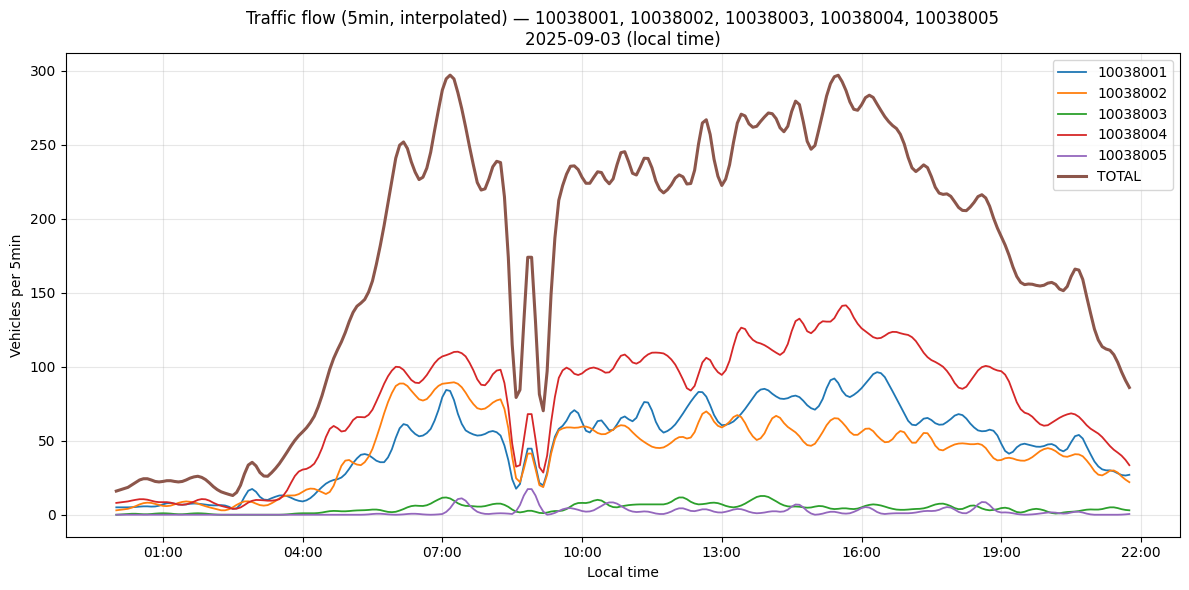

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------
# CONFIG
# ----------------------------
traffic_file  = "2025-9-3_TrafficFlow.txt"
selected_ids  = ["10038001","10038002","10038003","10038004","10038005"]
plot_date     = "2025-09-03"     # local date (Europe/Berlin)
local_tz      = "Europe/Berlin"

NATIVE_PERIOD = "15min"          # feed period (900 s)
PLOT_PERIOD   = "5min"           # target plotting grid
SMOOTH_WIN    = "20min"          # rolling-mean window; set None to disable

out_csv       = "traffic_5sensors_merged_FULLDAY_2025-09-03.csv"

# ----------------------------
# READ TWICE (7 cols & 8 cols)
# ----------------------------
names7 = ["idx","type","period","vehicleType","flow","DateTime","ID"]
names8 = ["idx","type","period","vehicleType","flow","occupancy","DateTime","ID"]

df7 = pd.read_csv(
    traffic_file,
    header=None, names=names7,
    usecols=[0,1,2,3,4,5,6],
    engine="python", on_bad_lines="skip"
)
df8 = pd.read_csv(
    traffic_file,
    header=None, names=names8,
    usecols=[0,1,2,3,4,5,6,7],
    engine="python", on_bad_lines="skip"
)

def clean(df, has_occupancy: bool):
    out = df.copy()
    out["ID"]   = (out["ID"].astype(str).str.strip()
                   .str.replace(r"\.0$", "", regex=True))
    out["flow"] = pd.to_numeric(out["flow"], errors="coerce")
    out["DateTime"] = pd.to_datetime(out["DateTime"], errors="coerce")
    # localize/convert
    if out["DateTime"].dt.tz is None:
        out["DateTimeLocal"] = out["DateTime"].dt.tz_localize(local_tz)
    else:
        out["DateTimeLocal"] = out["DateTime"].dt.tz_convert(local_tz)
    keep = ["ID","flow","DateTime","DateTimeLocal"]
    if has_occupancy and "occupancy" in out.columns:
        out["occupancy"] = pd.to_numeric(out["occupancy"], errors="coerce")
        keep.append("occupancy")
    return out[keep]

df7c = clean(df7, has_occupancy=False)
df8c = clean(df8, has_occupancy=True)

# Coalesce on (ID, DateTimeLocal floored to native period)
df7c["Key"] = list(zip(df7c["ID"], df7c["DateTimeLocal"].dt.floor(NATIVE_PERIOD)))
df8c["Key"] = list(zip(df8c["ID"], df8c["DateTimeLocal"].dt.floor(NATIVE_PERIOD)))
merged = pd.merge(df8c, df7c, on="Key", how="outer", suffixes=("_8","_7"))

def coalesce(a, b): return a.where(~a.isna(), b)

merged["ID"]            = coalesce(merged.get("ID_8"), merged.get("ID_7"))
merged["flow"]          = coalesce(merged.get("flow_8"), merged.get("flow_7"))
merged["DateTime"]      = coalesce(merged.get("DateTime_8"), merged.get("DateTime_7"))
merged["DateTimeLocal"] = coalesce(merged.get("DateTimeLocal_8"), merged.get("DateTimeLocal_7"))
if "occupancy_8" in merged.columns:
    merged["occupancy"] = merged["occupancy_8"]

merged = merged.dropna(subset=["ID","DateTimeLocal"])
merged = merged[merged["ID"].isin(selected_ids)].copy()

# Keep full local day
merged["Date"] = merged["DateTimeLocal"].dt.date.astype(str)
merged = merged[merged["Date"] == plot_date].copy()
if merged.empty:
    raise SystemExit("[WARN] No rows for the selected IDs on that day.")

# ----------------------------
# RESAMPLE: native → upsample → smooth
# ----------------------------
merged = merged.sort_values("DateTimeLocal")

# 1) Native cadence (15min): we use .sum() in case any duplicate stamps exist
native = (merged.set_index("DateTimeLocal")
                 .groupby("ID")["flow"]
                 .resample(NATIVE_PERIOD).sum()
                 .reset_index())

# 2) Pivot to wide native grid (NaNs between points, not zeros)
wide_native = (native.pivot(index="DateTimeLocal", columns="ID", values="flow")
                      .sort_index())

# 3) Upsample to finer grid via time interpolation (no zeros)
wide_plot = (wide_native
             .resample(PLOT_PERIOD).asfreq()           # insert NaN rows
             .interpolate(method="time", limit_area="inside"))

# 4) Optional smoothing (rolling mean over time)
if SMOOTH_WIN:
    wide_plot = wide_plot.rolling(SMOOTH_WIN, min_periods=1).mean()

# Save cleaned/processed
wide_plot.to_csv(out_csv)
print(f"[INFO] Saved cleaned/merged CSV: {out_csv}")
print(f"[INFO] Span: {wide_plot.index.min()} → {wide_plot.index.max()}")
print(f"[INFO] Sensors in plot: {list(wide_plot.columns)}")

# ----------------------------
# PLOT
# ----------------------------
plt.figure(figsize=(12,6))

# per-sensor lines
for col in wide_plot.columns:
    plt.plot(wide_plot.index, wide_plot[col], linewidth=1.3, label=col)

# total line (bold) — NaNs kept; bins with no data won’t fake zeros
total = wide_plot.sum(axis=1, min_count=1)
plt.plot(wide_plot.index, total, linewidth=2.2, label="TOTAL", zorder=5)

plt.title(f"Traffic flow ({PLOT_PERIOD}, interpolated) — {', '.join(selected_ids)}\n{plot_date} (local time)")
plt.xlabel("Local time")
plt.ylabel("Vehicles per " + PLOT_PERIOD)
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.legend(ncol=1, frameon=True, loc="upper right")
plt.tight_layout()
plt.show()

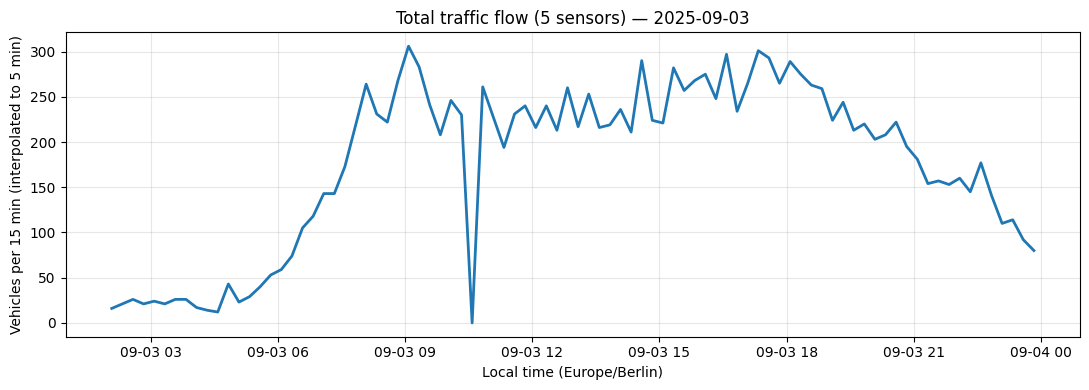

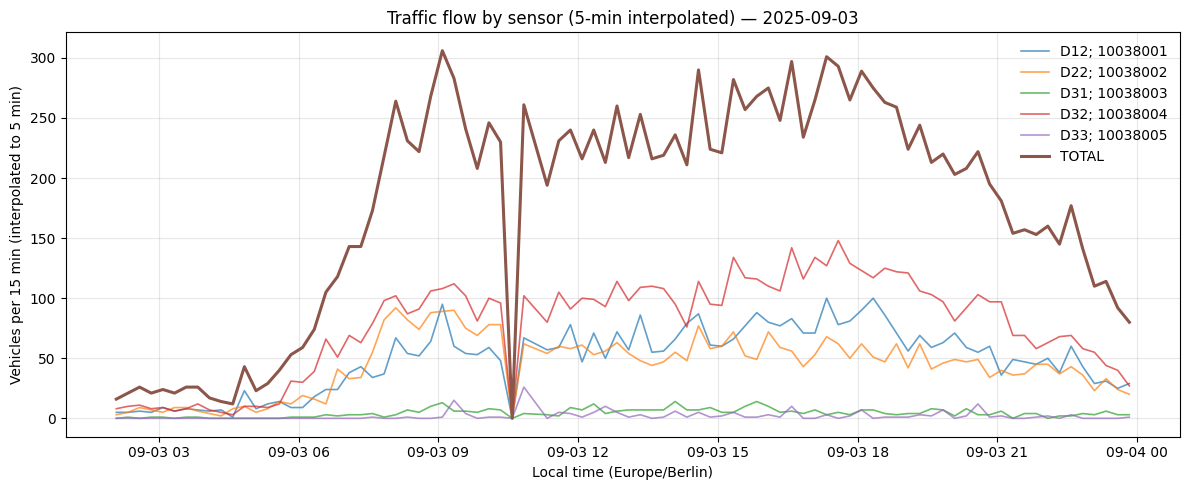

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

traffic_file = "2025-9-3_TrafficFlow.txt"
IDS = {"10038001","10038002","10038003","10038004","10038005"}
DAY = "2025-09-03"               # local day (Europe/Berlin)

usecols = ["@index",
           "measuredValue.basicData.@xsi:type",
           "measuredValue.basicData.measurementOrCalculationPeriod",
           "measuredValue.basicData.forVehiclesWithCharacteristicsOf.vehicleType",
           "measuredValue.basicData.vehicleFlow.vehicleFlowRate",
           "DateTime",
           "ID"]

chunks = []
for chunk in pd.read_csv(
        traffic_file,
        sep=r",+",
        engine="python",
        names=usecols,          # treat file as headerless
        header=None,
        usecols=usecols,
        dtype=str,              # read as strings to avoid header-text crashes
        on_bad_lines="skip",
        chunksize=200_000
    ):
    # drop any stray header rows inside the file
    mask_header = chunk["measuredValue.basicData.vehicleFlow.vehicleFlowRate"].eq(
        "measuredValue.basicData.vehicleFlow.vehicleFlowRate"
    )
    if mask_header.any():
        chunk = chunk[~mask_header]

    # parse datetime
    chunk["DateTime"] = pd.to_datetime(chunk["DateTime"], errors="coerce")

    # coerce flow to numeric (anything non-numeric -> NaN)
    chunk["flow"] = pd.to_numeric(
        chunk["measuredValue.basicData.vehicleFlow.vehicleFlowRate"],
        errors="coerce"
    )

    # filter rows we care about
    mask = (
        (chunk["measuredValue.basicData.@xsi:type"] == "TrafficFlow") &
        (chunk["measuredValue.basicData.forVehiclesWithCharacteristicsOf.vehicleType"] == "anyVehicle") &
        (chunk["ID"].isin(IDS))
    )
    sub = chunk.loc[mask, ["DateTime", "ID", "flow"]].dropna(subset=["DateTime", "flow"])
    chunks.append(sub)

df = pd.concat(chunks, ignore_index=True)

# work in local time for day slicing
df["DateTime_local"] = df["DateTime"].dt.tz_convert("Europe/Berlin")
df = df[df["DateTime_local"].dt.date.astype(str) == DAY]

if df.empty:
    raise SystemExit(f"No rows found for {DAY} and IDs {sorted(IDS)}.")

# pivot to wide (15-min native cadence), sort, resample to 5-min and interpolate to avoid spikes to zero
wide = (df.pivot_table(index="DateTime_local", columns="ID", values="flow", aggfunc="sum")
          .sort_index())

wide_5 = wide.resample("5min").interpolate("time")   # smooth line between 15-min points
total = wide_5.sum(axis=1, min_count=1)

# ---------- PLOTS ----------
# 1) Total across the 5 counters
plt.figure(figsize=(11,4))
plt.plot(total.index, total.values, lw=2)
plt.title(f"Total traffic flow (5 sensors) — {DAY}")
plt.xlabel("Local time (Europe/Berlin)")
plt.ylabel("Vehicles per 15 min (interpolated to 5 min)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Each sensor + total, with sensor info in legend
sensor_labels = {
    "10038001": "D12; 10038001",
    "10038002": "D22; 10038002",
    "10038003": "D31; 10038003",
    "10038004": "D32; 10038004",
    "10038005": "D33; 10038005"
}

plt.figure(figsize=(12,5))
for col in wide_5.columns:
    label = sensor_labels.get(str(col), str(col))
    plt.plot(wide_5.index, wide_5[col], lw=1.2, alpha=0.7, label=label)
plt.plot(total.index, total.values, lw=2.2, label="TOTAL", zorder=5)
plt.legend(ncol=1, frameon=False, loc="upper right")
plt.title(f"Traffic flow by sensor (5-min interpolated) — {DAY}")
plt.xlabel("Local time (Europe/Berlin)")
plt.ylabel("Vehicles per 15 min (interpolated to 5 min)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

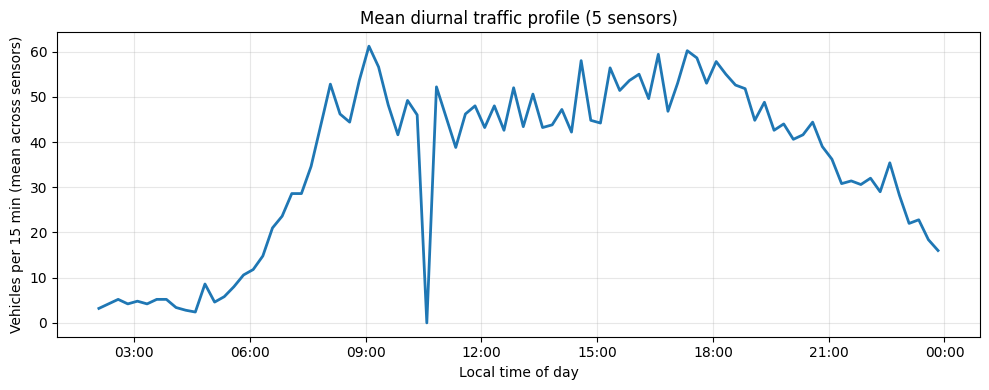

In [61]:
# --- TIME-OF-DAY MEAN PROFILE (across the 5 sensors) ---

# 1) Mean across sensors at each timestamp
mean_across_sensors = wide_5.mean(axis=1, skipna=True)

# 2) Compute the "clock time" in local time (drop date, keep HH:MM:SS)
clock = mean_across_sensors.index.tz_convert("Europe/Berlin").floor("5min").time

# 3) Average by clock time (useful if you later compare multiple days)
mean_by_clock = (
    pd.DataFrame({"flow": mean_across_sensors.values, "clock": clock})
    .groupby("clock")["flow"].mean()
)

# 4) Convert clock (datetime.time) -> dummy pandas Timestamp for plotting
clock_ts = pd.to_datetime(mean_by_clock.index.astype(str), format="%H:%M:%S")

# 5) Plot
import matplotlib.dates as mdates
plt.figure(figsize=(10, 4))
plt.plot(clock_ts, mean_by_clock.values, lw=2)
plt.title("Mean diurnal traffic profile (5 sensors)")
plt.xlabel("Local time of day")
plt.ylabel("Vehicles per 15 min (mean across sensors)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



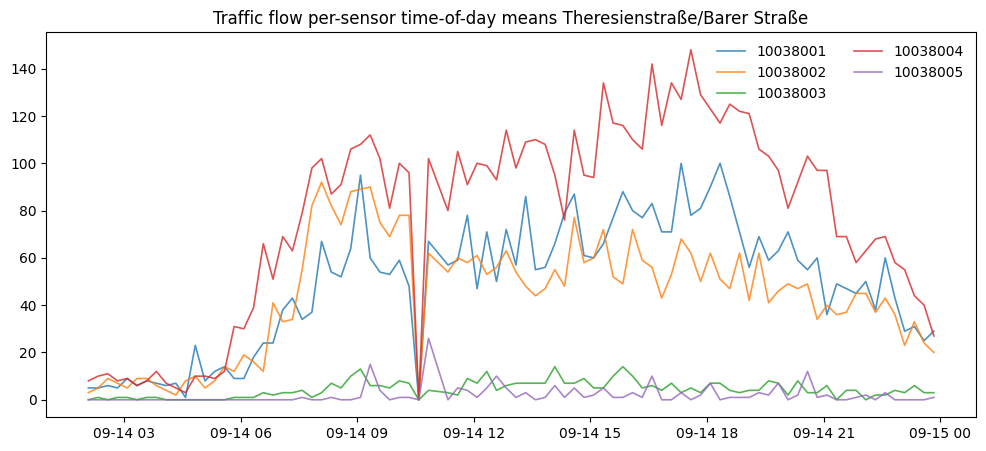

In [62]:
# Per-sensor mean profiles by clock time
profiles = []
for col in wide_5.columns:
    if col == "time_of_day":  # in case you added such a column earlier
        continue
    s = wide_5[col]
    clock = s.index.tz_convert("Europe/Berlin").floor("5min").time
    m = (pd.DataFrame({"flow": s.values, "clock": clock})
           .groupby("clock")["flow"].mean())
    profiles.append((col, m))

plt.figure(figsize=(12, 5))
for col, m in profiles:
    plt.plot(pd.to_datetime(m.index.astype(str)), m.values, lw=1.2, alpha=0.8, label=col)

plt.title("Traffic flow per-sensor time-of-day means Theresienstraße/Barer Straße")
plt.legend(ncol=2, frameon=False, loc="upper right")


In [63]:
# --- Traffic summary stats ---
print("=== Traffic Summary for 2025-09-03 (5 sensors) ===")
print(f"Total rows (5-min interpolated): {len(total)}")

# Overall mean, max, min
print(f"Overall mean traffic (vehicles/15 min): {total.mean():.1f}")
print(f"Overall max traffic (vehicles/15 min): {total.max():.1f} at {total.idxmax()}")

# Midday window (11:00–14:00 local)
midday = total.between_time("11:00", "14:00")
print(f"Midday mean (11–14h): {midday.mean():.1f}")
print(f"Midday max: {midday.max():.1f} at {midday.idxmax()}")

# Afternoon rush (15:00–18:30 local)
afternoon = total.between_time("15:00", "18:30")
print(f"Afternoon mean (15–18:30h): {afternoon.mean():.1f}")
print(f"Afternoon max: {afternoon.max():.1f} at {afternoon.idxmax()}")

# Evening (after 18:30)
evening = total.between_time("18:30", "20:00")
print(f"Evening mean (18:30–20h): {evening.mean():.1f}")

=== Traffic Summary for 2025-09-03 (5 sensors) ===
Total rows (5-min interpolated): 262
Overall mean traffic (vehicles/15 min): 178.0
Overall max traffic (vehicles/15 min): 306.0 at 2025-09-03 09:05:00+02:00
Midday mean (11–14h): 227.7
Midday max: 260.0 at 2025-09-03 12:50:00+02:00
Afternoon mean (15–18:30h): 269.2
Afternoon max: 301.0 at 2025-09-03 17:20:00+02:00
Evening mean (18:30–20h): 235.6


Pearson r (no lag): 0.188  [n=40]
Lag scan (Traffic leads NO2):
  lag -30 min: r=-0.836
  lag -25 min: r=0.380
  lag -20 min: r=0.738
  lag -15 min: r=-0.353
  lag -10 min: r=0.013
  lag -5 min: r=0.159
  lag +0 min: r=0.188
  lag +5 min: r=0.192
  lag +10 min: r=0.288
  lag +15 min: r=0.796
  lag +20 min: r=0.713
  lag +25 min: r=0.762
  lag +30 min: r=0.573
Best lag = +15 min with r=0.796


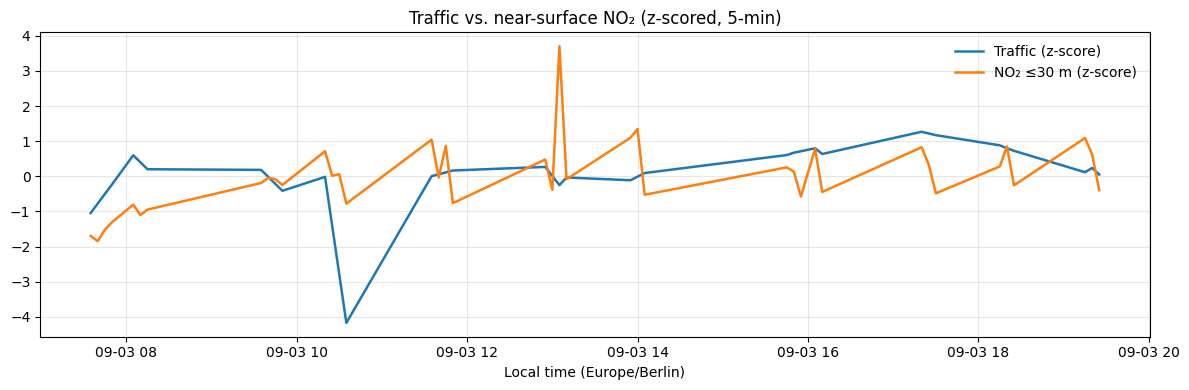

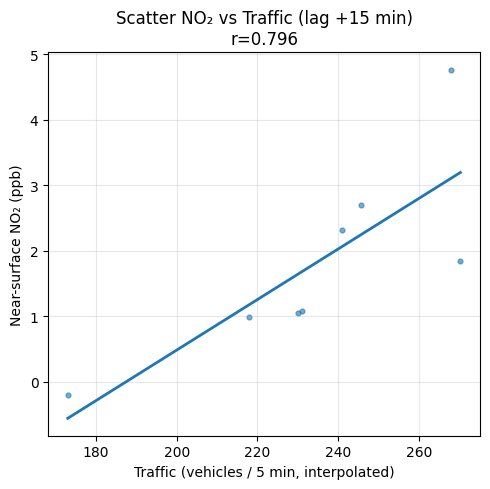

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------- CONFIG (edit if needed) -----------
sensor_file = "mini-airquix19calibration_result2025-09-03_02.txt"
NO2_COL     = "predicted_NO2"

flight_files = {
    "Flight 1":  "Sep-3rd-2025-01-05PM-Flight-Airdata.csv",
    "Flight 2":  "Sep-3rd-2025-01-55PM-Flight-Airdata.csv",
    "Flight 3":  "Sep-3rd-2025-02-01PM-Flight-Airdata.csv",
    "Flight 4":  "Sep-3rd-2025-03-47PM-Flight-Airdata.csv",
    "Flight 5":  "Sep-3rd-2025-03-53PM-Flight-Airdata.csv",
    "Flight 6":  "Sep-3rd-2025-04-09PM-Flight-Airdata.csv",
    "Flight 7":  "Sep-3rd-2025-05-20PM-Flight-Airdata.csv",
    "Flight 8":  "Sep-3rd-2025-05-28PM-Flight-Airdata.csv",
    "Flight 9":  "Sep-3rd-2025-06-17PM-Flight-Airdata.csv",
    "Flight 10": "Sep-3rd-2025-06-23PM-Flight-Airdata.csv",
    "Flight 11": "Sep-3rd-2025-07-17PM-Flight-Airdata.csv",
    "Flight 12": "Sep-3rd-2025-07-23PM-Flight-Airdata.csv",
    "Flight 13": "Sep-3rd-2025-07-35AM-Flight-Airdata.csv",
    "Flight 14": "Sep-3rd-2025-07-41AM-Flight-Airdata.csv",
    "Flight 15": "Sep-3rd-2025-07-47AM-Flight-Airdata.csv",
    "Flight 16": "Sep-3rd-2025-08-05AM-Flight-Airdata.csv",
    "Flight 17": "Sep-3rd-2025-08-12AM-Flight-Airdata.csv",
    "Flight 18": "Sep-3rd-2025-09-35AM-Flight-Airdata.csv",
    "Flight 19": "Sep-3rd-2025-09-42AM-Flight-Airdata.csv",
    "Flight 20": "Sep-3rd-2025-09-46AM-Flight-Airdata.csv",
    "Flight 21": "Sep-3rd-2025-10-22AM-Flight-Airdata.csv",
    "Flight 22": "Sep-3rd-2025-10-29AM-Flight-Airdata.csv",
    "Flight 23": "Sep-3rd-2025-11-39AM-Flight-Airdata.csv",
    "Flight 24": "Sep-3rd-2025-11-45AM-Flight-Airdata.csv",
    "Flight 25": "Sep-3rd-2025-12-57PM-Flight-Airdata.csv",
}

# downwash correction (optional; uses zSpeed if present)
LOOKAHEAD_S = 0.5      # tau
MERGE_TOL   = "8s"
NEAR_SURF_M = 30       # define "near-surface"
TIME_BIN    = "5min"

# ----------- Build near-surface NO2 (5-min, local tz) -----------
def build_no2_near_surface_series():
    # sensor (local -> UTC)
    sens = pd.read_csv(sensor_file, on_bad_lines="skip")
    sens["DateTime"] = pd.to_datetime(sens["DateTime"], errors="coerce")
    sens = sens.dropna(subset=["DateTime"])
    sens["DateTime"] = sens["DateTime"].dt.tz_localize("Europe/Berlin").dt.tz_convert("UTC")
    if NO2_COL not in sens.columns:
        raise KeyError(f"{NO2_COL} not found in {sensor_file}")
    sens = sens[["DateTime", NO2_COL]].rename(columns={NO2_COL:"NO2_ppb"}).sort_values("DateTime")

    rows = []
    for label, f in flight_files.items():
        try:
            d = pd.read_csv(f, on_bad_lines="skip", low_memory=False)
        except FileNotFoundError:
            continue
        if "datetime(utc)" not in d.columns or "height_above_takeoff(feet)" not in d.columns:
            continue
        d["DateTime"] = pd.to_datetime(d["datetime(utc)"], errors="coerce").dt.tz_localize("UTC")
        d = d.dropna(subset=["DateTime"]).sort_values("DateTime")
        if d.empty:
            continue

        # altitude (m)
        d["alt_m"] = pd.to_numeric(d["height_above_takeoff(feet)"], errors="coerce") * 0.3048

        # optional downwash correction if zSpeed available
        z_col = next((c for c in d.columns if c.strip()=="zSpeed(mph)"), None)
        if z_col is not None:
            d["z_mps"] = pd.to_numeric(d[z_col], errors="coerce") * 0.44704
            d["alt_eff_m"] = d["alt_m"] + d["z_mps"] * LOOKAHEAD_S
        else:
            d["alt_eff_m"] = d["alt_m"]

        m = pd.merge_asof(d[["DateTime","alt_eff_m"]].sort_values("DateTime"),
                          sens.sort_values("DateTime"),
                          on="DateTime", direction="nearest",
                          tolerance=pd.Timedelta(MERGE_TOL))
        m = m.dropna(subset=["alt_eff_m","NO2_ppb"])
        if m.empty:
            continue
        rows.append(m)

    if not rows:
        raise RuntimeError("No merged UAV/NO2 rows built — check files/columns.")
    df = pd.concat(rows, ignore_index=True)

    # to local tz and keep near-surface only
    df["TimeLocal"] = df["DateTime"].dt.tz_convert("Europe/Berlin")
    near = df[df["alt_eff_m"] <= NEAR_SURF_M].copy()
    if near.empty:
        raise RuntimeError(f"No near-surface points (<= {NEAR_SURF_M} m).")

    # 5-min mean NO2 (ppb)
    no2_5 = (near.set_index("TimeLocal")["NO2_ppb"]
                  .sort_index()
                  .resample(TIME_BIN).mean())
    return no2_5

# Build near-surface NO2 series
no2_near = build_no2_near_surface_series()

# ----------- Align with traffic 'total' (which you already computed) -----------
# Ensure both are in same tz & 5-min cadence
no2_near = no2_near.tz_convert("Europe/Berlin")
traffic_5 = total.copy()  # your existing series (Europe/Berlin, 5-min)

# Align on intersection
joint = pd.concat([traffic_5.rename("Traffic"), no2_near.rename("NO2")], axis=1).dropna()
if joint.empty:
    raise RuntimeError("No time overlap between traffic and NO₂ series after alignment.")

# ----------- Correlation (no lag) -----------
r0 = joint["Traffic"].corr(joint["NO2"])
print(f"Pearson r (no lag): {r0:.3f}  [n={len(joint)}]")

# ----------- Small lag sweep (traffic leads NO2) -----------
def lag_corr(x, y, minutes):
    return x.shift(minutes, freq="min").corr(y)

lags = range(-30, 31, 5)  # -30 to +30 min in 5-min steps
scan = []
for L in lags:
    rL = lag_corr(joint["Traffic"], joint["NO2"], L)
    scan.append((L, rL))
bestL, bestR = max(scan, key=lambda t: (t[1] if pd.notna(t[1]) else -np.inf))
print("Lag scan (Traffic leads NO2):")
for L, r in scan:
    print(f"  lag {L:+d} min: r={r:.3f}" if pd.notna(r) else f"  lag {L:+d} min: r=NaN")
print(f"Best lag = {bestL:+d} min with r={bestR:.3f}")

# ----------- Plots -----------
# Time series overlay (normalized to compare shape)
z_tr = (joint["Traffic"] - joint["Traffic"].mean())/joint["Traffic"].std()
z_no2 = (joint["NO2"] - joint["NO2"].mean())/joint["NO2"].std()

plt.figure(figsize=(12,4))
plt.plot(z_tr.index, z_tr, label="Traffic (z-score)", lw=1.8)
plt.plot(z_no2.index, z_no2, label="NO₂ ≤30 m (z-score)", lw=1.8)
plt.legend(frameon=False)
plt.title("Traffic vs. near-surface NO₂ (z-scored, 5-min)")
plt.xlabel("Local time (Europe/Berlin)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter at best lag
aligned = pd.concat([
    joint["Traffic"].shift(bestL, freq="min").rename(f"Traffic (lag {bestL:+d} min)"),
    joint["NO2"]
], axis=1).dropna()

plt.figure(figsize=(5,5))
plt.scatter(aligned.iloc[:,0], aligned["NO2"], s=12, alpha=0.6)
m, b = np.polyfit(aligned.iloc[:,0], aligned["NO2"], 1)
xline = np.linspace(aligned.iloc[:,0].min(), aligned.iloc[:,0].max(), 200)
plt.plot(xline, m*xline+b, lw=2)
plt.title(f"Scatter NO₂ vs Traffic (lag {bestL:+d} min)\nr={bestR:.3f}")
plt.xlabel("Traffic (vehicles / 5 min, interpolated)")
plt.ylabel("Near-surface NO₂ (ppb)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

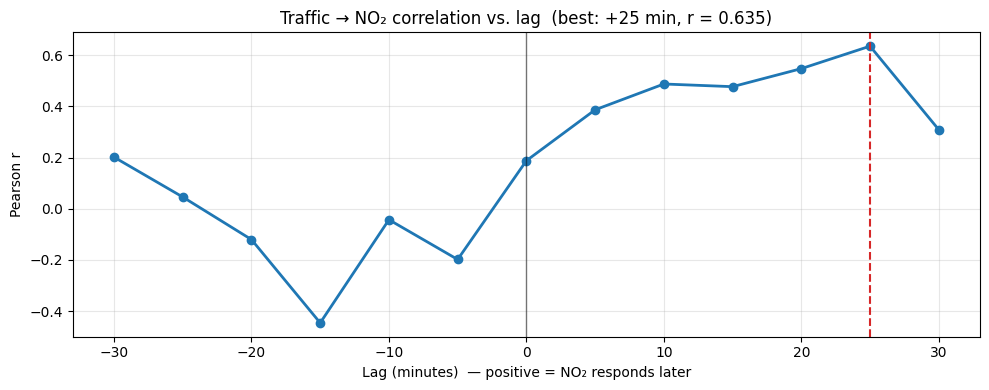

In [65]:
import numpy as np
import matplotlib.pyplot as plt

lags_min = np.arange(-30, 31, 5)  # minutes
corrs = []

for L in lags_min:
    # shift NO2 by +L (i.e., traffic leads by L if L>0)
    no2_L = no2_near.shift(-L, freq="5min")
    pair = pd.concat({"traffic": total, "no2": no2_L}, axis=1).dropna()
    if len(pair) >= 6:  # need a few points to be meaningful
        corrs.append(pair["traffic"].corr(pair["no2"]))
    else:
        corrs.append(np.nan)

corrs = pd.Series(corrs, index=lags_min)

best_lag = corrs.idxmax()
best_r   = corrs.max()

plt.figure(figsize=(10,4))
plt.plot(corrs.index, corrs.values, marker="o", linewidth=2)
plt.axvline(0, color="k", linewidth=1, alpha=0.5)
plt.axvline(best_lag, color="tab:red", linestyle="--", linewidth=1.5)
plt.title(f"Traffic → NO₂ correlation vs. lag  (best: +{best_lag} min, r = {best_r:.3f})")
plt.xlabel("Lag (minutes)  — positive = NO₂ responds later")
plt.ylabel("Pearson r")
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("correlation_vs_lag.png", dpi=200)
plt.show()

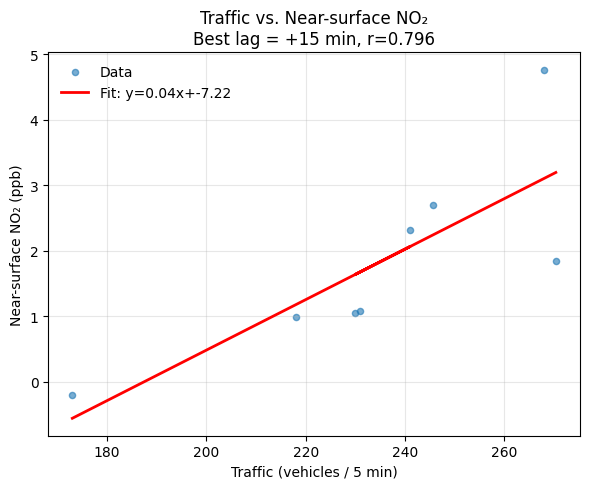

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# aligned = DataFrame with traffic and NO2 columns (already aligned with lag)
x = aligned.iloc[:,0]   # traffic (vehicles/5 min)
y = aligned["NO2"]      # near-surface NO₂ (ppb)

# Linear regression (numpy polyfit)
m, b = np.polyfit(x, y, 1)

# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(x, y, s=20, alpha=0.6, label="Data")
plt.plot(x, m*x + b, color="red", lw=2, label=f"Fit: y={m:.2f}x+{b:.2f}")

# Labels and style
plt.title(f"Traffic vs. Near-surface NO₂\nBest lag = {bestL:+d} min, r={bestR:.3f}")
plt.xlabel("Traffic (vehicles / 5 min)")
plt.ylabel("Near-surface NO₂ (ppb)")
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

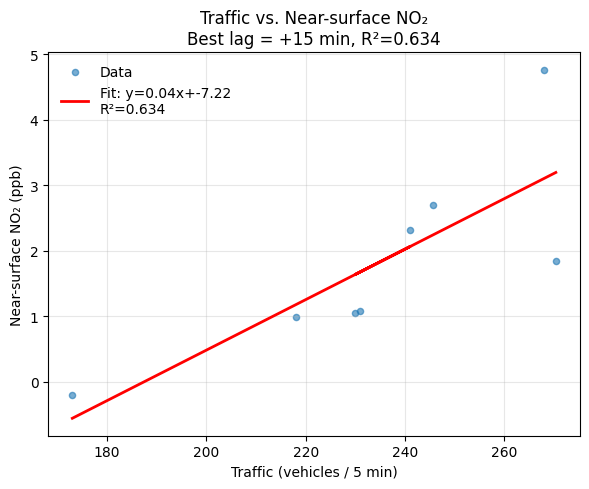

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# aligned = DataFrame with traffic and NO2 columns (already aligned with lag)
x = aligned.iloc[:,0]   # traffic (vehicles/5 min)
y = aligned["NO2"]      # near-surface NO₂ (ppb)

# Linear regression (numpy polyfit)
m, b = np.polyfit(x, y, 1)
y_pred = m*x + b

# Compute R²
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(x, y, s=20, alpha=0.6, label="Data")
plt.plot(x, y_pred, color="red", lw=2,
         label=f"Fit: y={m:.2f}x+{b:.2f}\nR²={r2:.3f}")

# Labels and style
plt.title(f"Traffic vs. Near-surface NO₂\nBest lag = {bestL:+d} min, R²={r2:.3f}")
plt.xlabel("Traffic (vehicles / 5 min)")
plt.ylabel("Near-surface NO₂ (ppb)")
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

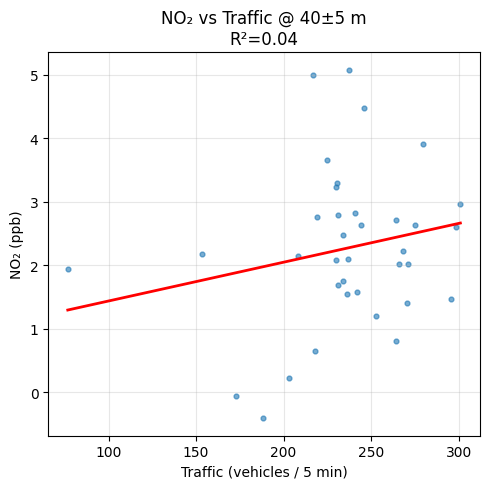

In [74]:
# --- Pick an altitude bin for analysis ---
ALT_TARGET = 40        # meters above ground
ALT_TOL    = 5         # tolerance window ± (so 35–45 m)

def build_no2_at_alt_series(alt_target=ALT_TARGET, alt_tol=ALT_TOL):
    sens = pd.read_csv(sensor_file, on_bad_lines="skip")
    sens["DateTime"] = pd.to_datetime(sens["DateTime"], errors="coerce")
    sens = sens.dropna(subset=["DateTime"])
    sens["DateTime"] = sens["DateTime"].dt.tz_localize("Europe/Berlin").dt.tz_convert("UTC")
    sens = sens[["DateTime", NO2_COL]].rename(columns={NO2_COL:"NO2_ppb"}).sort_values("DateTime")

    rows = []
    for label, f in flight_files.items():
        try:
            d = pd.read_csv(f, on_bad_lines="skip", low_memory=False)
        except FileNotFoundError:
            continue
        if "datetime(utc)" not in d.columns or "height_above_takeoff(feet)" not in d.columns:
            continue
        d["DateTime"] = pd.to_datetime(d["datetime(utc)"], errors="coerce").dt.tz_localize("UTC")
        d = d.dropna(subset=["DateTime"]).sort_values("DateTime")
        if d.empty:
            continue

        # altitude in meters
        d["alt_m"] = pd.to_numeric(d["height_above_takeoff(feet)"], errors="coerce") * 0.3048

        # effective altitude (downwash correction if available)
        z_col = next((c for c in d.columns if c.strip()=="zSpeed(mph)"), None)
        if z_col is not None:
            d["z_mps"] = pd.to_numeric(d[z_col], errors="coerce") * 0.44704
            d["alt_eff_m"] = d["alt_m"] + d["z_mps"] * LOOKAHEAD_S
        else:
            d["alt_eff_m"] = d["alt_m"]

        m = pd.merge_asof(
            d[["DateTime","alt_eff_m"]].sort_values("DateTime"),
            sens.sort_values("DateTime"),
            on="DateTime", direction="nearest",
            tolerance=pd.Timedelta(MERGE_TOL)
        ).dropna()

        if m.empty:
            continue

        # filter to target altitude ± tol
        mask = (m["alt_eff_m"] >= alt_target-alt_tol) & (m["alt_eff_m"] <= alt_target+alt_tol)
        m = m.loc[mask]
        if not m.empty:
            rows.append(m)

    if not rows:
        raise RuntimeError(f"No merged UAV/NO₂ rows at {alt_target}±{alt_tol} m.")
    df = pd.concat(rows, ignore_index=True)
    df["TimeLocal"] = df["DateTime"].dt.tz_convert("Europe/Berlin")

    # resample to TIME_BIN (5 min) for alignment with traffic
    return (df.set_index("TimeLocal")["NO2_ppb"]
              .sort_index()
              .resample(TIME_BIN).mean())

# Build NO₂ series at chosen altitude
no2_at_alt = build_no2_at_alt_series(ALT_TARGET, ALT_TOL)

# --- Align with traffic total ---
joint = pd.concat([traffic_5.rename("Traffic"), no2_at_alt.rename("NO2")], axis=1).dropna()

# --- Linear regression and scatter ---
plt.figure(figsize=(5,5))
plt.scatter(joint["Traffic"], joint["NO2"], s=12, alpha=0.6)
m, b = np.polyfit(joint["Traffic"], joint["NO2"], 1)
xline = np.linspace(joint["Traffic"].min(), joint["Traffic"].max(), 200)
plt.plot(xline, m*xline+b, color="red", lw=2)

# Compute R²
y_pred = m*joint["Traffic"]+b
ss_res = np.sum((joint["NO2"]-y_pred)**2)
ss_tot = np.sum((joint["NO2"]-joint["NO2"].mean())**2)
r2 = 1 - ss_res/ss_tot

plt.title(f"NO₂ vs Traffic @ {ALT_TARGET}±{ALT_TOL} m\nR²={r2:.2f}")
plt.xlabel("Traffic (vehicles / 5 min)")
plt.ylabel("NO₂ (ppb)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

     bin  n    slope  intercept       R2
  0-30 m 40 0.008003   1.037817 0.035401
 30-60 m 36 0.005368   0.965099 0.037967
 60-90 m 34 0.003221   1.137144 0.033428
90-120 m 32 0.005420   0.364012 0.081830


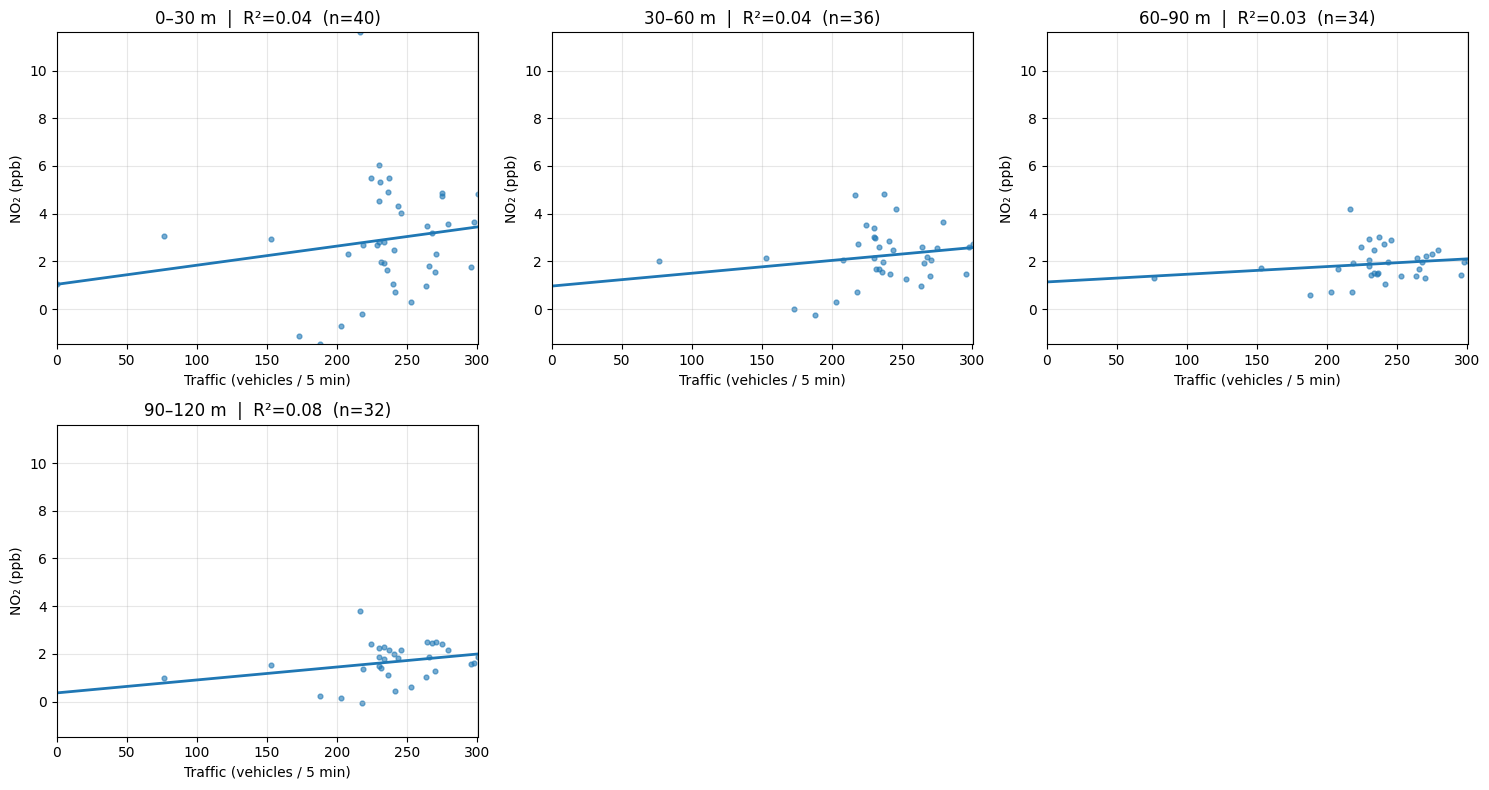

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG: altitude bin edges (m)
# -----------------------------
BIN_EDGES = np.arange(0, 121, 20)   # -> [0–20), [20–40), …, [100–120]
BIN_EDGES = [0, 30, 60, 90, 120]  # example custom bins

def build_no2_for_bin(lo, hi):
    """Return a 5-min NO2 series (local tz) filtered to lo<=alt_eff_m<hi."""
    sens = pd.read_csv(sensor_file, on_bad_lines="skip")
    sens["DateTime"] = pd.to_datetime(sens["DateTime"], errors="coerce")
    sens = sens.dropna(subset=["DateTime"])
    sens["DateTime"] = sens["DateTime"].dt.tz_localize("Europe/Berlin").dt.tz_convert("UTC")
    sens = sens[["DateTime", NO2_COL]].rename(columns={NO2_COL:"NO2_ppb"}).sort_values("DateTime")

    rows = []
    for label, f in flight_files.items():
        try:
            d = pd.read_csv(f, on_bad_lines="skip", low_memory=False)
        except FileNotFoundError:
            continue
        if "datetime(utc)" not in d.columns or "height_above_takeoff(feet)" not in d.columns:
            continue

        d["DateTime"] = pd.to_datetime(d["datetime(utc)"], errors="coerce").dt.tz_localize("UTC")
        d = d.dropna(subset=["DateTime"]).sort_values("DateTime")
        if d.empty: 
            continue

        # altitude (m)
        d["alt_m"] = pd.to_numeric(d["height_above_takeoff(feet)"], errors="coerce") * 0.3048

        # optional downwash correction if zSpeed available
        z_col = next((c for c in d.columns if c.strip()=="zSpeed(mph)"), None)
        if z_col is not None:
            d["z_mps"] = pd.to_numeric(d[z_col], errors="coerce") * 0.44704
            d["alt_eff_m"] = d["alt_m"] + d["z_mps"] * LOOKAHEAD_S
        else:
            d["alt_eff_m"] = d["alt_m"]

        m = pd.merge_asof(
            d[["DateTime","alt_eff_m"]].sort_values("DateTime"),
            sens.sort_values("DateTime"),
            on="DateTime", direction="nearest",
            tolerance=pd.Timedelta(MERGE_TOL)
        ).dropna()

        if m.empty:
            continue

        # filter to bin
        m = m[(m["alt_eff_m"] >= lo) & (m["alt_eff_m"] < hi)]
        if not m.empty:
            rows.append(m)

    if not rows:
        return pd.Series(dtype=float)

    df = pd.concat(rows, ignore_index=True)
    df["TimeLocal"] = df["DateTime"].dt.tz_convert("Europe/Berlin")
    no2_bin = (df.set_index("TimeLocal")["NO2_ppb"]
                 .sort_index()
                 .resample(TIME_BIN).mean())
    return no2_bin

# -----------------------------
# Build NO2 series per bin
# -----------------------------
bins = list(zip(BIN_EDGES[:-1], BIN_EDGES[1:]))
series_per_bin = {}
for lo, hi in bins:
    s = build_no2_for_bin(lo, hi)
    if not s.empty:
        series_per_bin[(lo, hi)] = s

if not series_per_bin:
    raise RuntimeError("No NO₂ data in any altitude bin.")

# -----------------------------
# Prepare joint data & fit per bin
# -----------------------------
results = []
xlims = []
ylims = []

# Ensure traffic is 5-min, local tz (you already had 'traffic_5')
traffic_5 = traffic_5.tz_convert("Europe/Berlin").asfreq(TIME_BIN)

for (lo, hi), no2_s in series_per_bin.items():
    joint = pd.concat([traffic_5.rename("Traffic"), no2_s.rename("NO2")], axis=1).dropna()
    if len(joint) < 3:
        continue

    # linear fit
    x = joint["Traffic"].values
    y = joint["NO2"].values
    m, b = np.polyfit(x, y, 1)
    y_pred = m*x + b

    # R^2
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    results.append({"bin": f"{lo}-{hi} m", "n": len(joint), "slope": m, "intercept": b, "R2": r2})
    xlims.append((x.min(), x.max()))
    ylims.append((y.min(), y.max()))

# If nothing survived:
if not results:
    raise RuntimeError("No overlapping Traffic–NO₂ points after alignment.")

stats_df = pd.DataFrame(results).sort_values("bin")
print(stats_df.to_string(index=False))

# -----------------------------
# Scatter subplots per bin
# -----------------------------
n = len(stats_df)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
axes = axes.ravel()

# common axes for comparability
x_min = min(lo for lo, hi in xlims)
x_max = max(hi for lo, hi in xlims)
y_min = min(lo for lo, hi in ylims)
y_max = max(hi for lo, hi in ylims)

i = 0
for (lo, hi) in [tuple(map(int, r["bin"].split()[0].split("-"))) for _, r in stats_df.iterrows()]:
    ax = axes[i]
    joint = pd.concat([traffic_5.rename("Traffic"),
                       series_per_bin[(lo, hi)].rename("NO2")], axis=1).dropna()
    x = joint["Traffic"].values
    y = joint["NO2"].values
    m = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "slope"].values[0]
    b = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "intercept"].values[0]
    r2 = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "R2"].values[0]

    ax.scatter(x, y, s=12, alpha=0.6)
    xx = np.linspace(x_min, x_max, 200)
    ax.plot(xx, m*xx + b, lw=2)

    ax.set_title(f"{lo}–{hi} m  |  R²={r2:.2f}  (n={len(joint)})")
    ax.set_xlabel("Traffic (vehicles / 5 min)")
    ax.set_ylabel("NO₂ (ppb)")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    i += 1

# hide any leftover empty axes
for j in range(i, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
plt.show()

     bin  n    slope  intercept       R2
  0-30 m 40 0.008003   1.037817 0.035401
 30-60 m 36 0.005368   0.965099 0.037967
 60-90 m 34 0.003221   1.137144 0.033428
90-120 m 32 0.005420   0.364012 0.081830


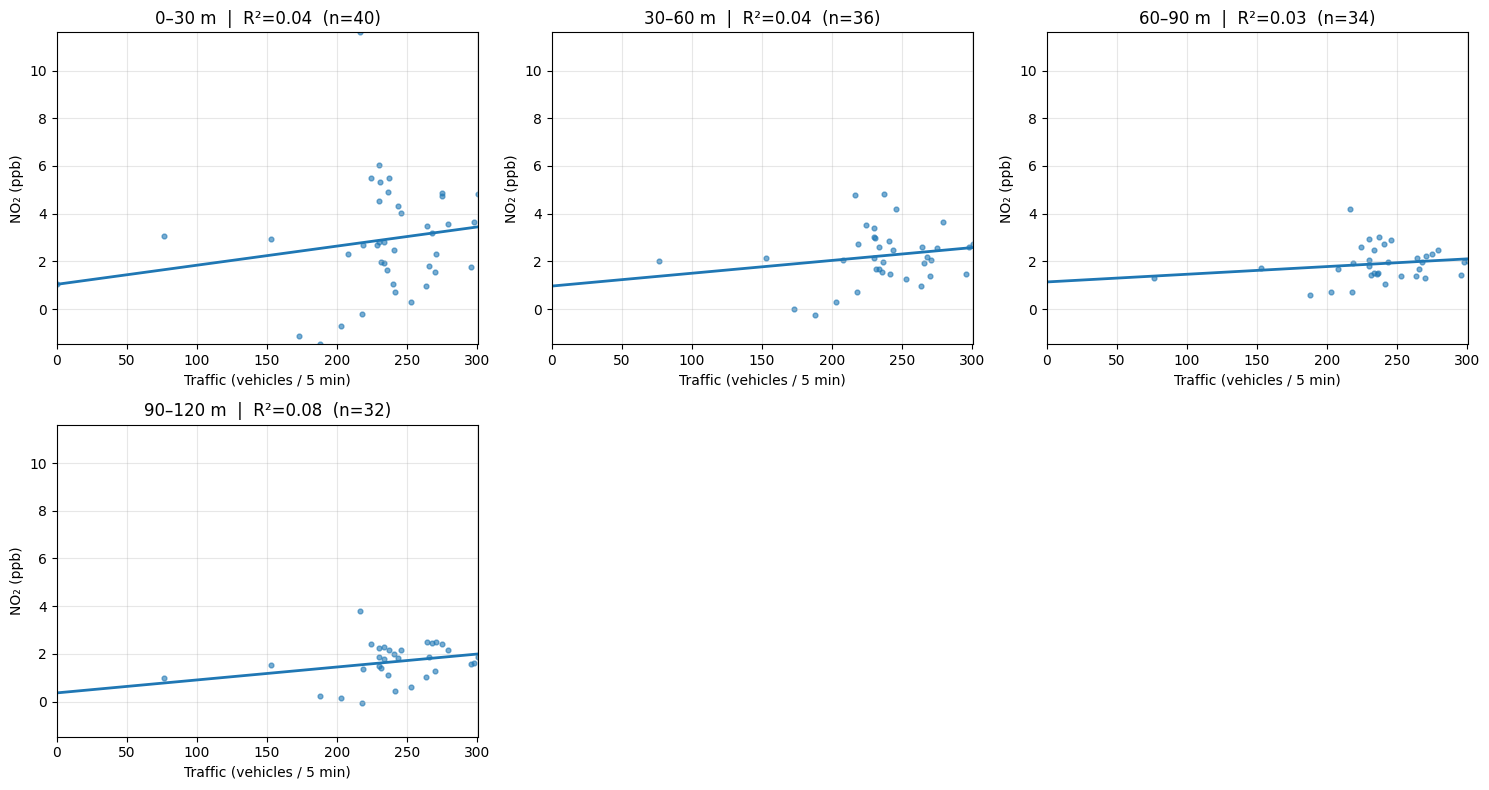

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG: altitude bin edges (m)
# -----------------------------
BIN_EDGES = np.arange(0, 121, 20)   # -> [0–20), [20–40), …, [100–120]
BIN_EDGES = [0, 30, 60, 90, 120]  # example custom bins

def build_no2_for_bin(lo, hi):
    """Return a 5-min NO2 series (local tz) filtered to lo<=alt_eff_m<hi."""
    sens = pd.read_csv(sensor_file, on_bad_lines="skip")
    sens["DateTime"] = pd.to_datetime(sens["DateTime"], errors="coerce")
    sens = sens.dropna(subset=["DateTime"])
    sens["DateTime"] = sens["DateTime"].dt.tz_localize("Europe/Berlin").dt.tz_convert("UTC")
    sens = sens[["DateTime", NO2_COL]].rename(columns={NO2_COL:"NO2_ppb"}).sort_values("DateTime")

    rows = []
    for label, f in flight_files.items():
        try:
            d = pd.read_csv(f, on_bad_lines="skip", low_memory=False)
        except FileNotFoundError:
            continue
        if "datetime(utc)" not in d.columns or "height_above_takeoff(feet)" not in d.columns:
            continue

        d["DateTime"] = pd.to_datetime(d["datetime(utc)"], errors="coerce").dt.tz_localize("UTC")
        d = d.dropna(subset=["DateTime"]).sort_values("DateTime")
        if d.empty: 
            continue

        # altitude (m)
        d["alt_m"] = pd.to_numeric(d["height_above_takeoff(feet)"], errors="coerce") * 0.3048

        # optional downwash correction if zSpeed available
        z_col = next((c for c in d.columns if c.strip()=="zSpeed(mph)"), None)
        if z_col is not None:
            d["z_mps"] = pd.to_numeric(d[z_col], errors="coerce") * 0.44704
            d["alt_eff_m"] = d["alt_m"] + d["z_mps"] * LOOKAHEAD_S
        else:
            d["alt_eff_m"] = d["alt_m"]

        m = pd.merge_asof(
            d[["DateTime","alt_eff_m"]].sort_values("DateTime"),
            sens.sort_values("DateTime"),
            on="DateTime", direction="nearest",
            tolerance=pd.Timedelta(MERGE_TOL)
        ).dropna()

        if m.empty:
            continue

        # filter to bin
        m = m[(m["alt_eff_m"] >= lo) & (m["alt_eff_m"] < hi)]
        if not m.empty:
            rows.append(m)

    if not rows:
        return pd.Series(dtype=float)

    df = pd.concat(rows, ignore_index=True)
    df["TimeLocal"] = df["DateTime"].dt.tz_convert("Europe/Berlin")
    no2_bin = (df.set_index("TimeLocal")["NO2_ppb"]
                 .sort_index()
                 .resample(TIME_BIN).mean())
    return no2_bin

# -----------------------------
# Build NO2 series per bin
# -----------------------------
bins = list(zip(BIN_EDGES[:-1], BIN_EDGES[1:]))
series_per_bin = {}
for lo, hi in bins:
    s = build_no2_for_bin(lo, hi)
    if not s.empty:
        series_per_bin[(lo, hi)] = s

if not series_per_bin:
    raise RuntimeError("No NO₂ data in any altitude bin.")

# -----------------------------
# Prepare joint data & fit per bin
# -----------------------------
results = []
xlims = []
ylims = []

# Ensure traffic is 5-min, local tz (you already had 'traffic_5')
traffic_5 = traffic_5.tz_convert("Europe/Berlin").asfreq(TIME_BIN)

for (lo, hi), no2_s in series_per_bin.items():
    joint = pd.concat([traffic_5.rename("Traffic"), no2_s.rename("NO2")], axis=1).dropna()
    if len(joint) < 3:
        continue

    # linear fit
    x = joint["Traffic"].values
    y = joint["NO2"].values
    m, b = np.polyfit(x, y, 1)
    y_pred = m*x + b

    # R^2
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    results.append({"bin": f"{lo}-{hi} m", "n": len(joint), "slope": m, "intercept": b, "R2": r2})
    xlims.append((x.min(), x.max()))
    ylims.append((y.min(), y.max()))

# If nothing survived:
if not results:
    raise RuntimeError("No overlapping Traffic–NO₂ points after alignment.")

stats_df = pd.DataFrame(results).sort_values("bin")
print(stats_df.to_string(index=False))

# -----------------------------
# Scatter subplots per bin
# -----------------------------
n = len(stats_df)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
axes = axes.ravel()

# common axes for comparability
x_min = min(lo for lo, hi in xlims)
x_max = max(hi for lo, hi in xlims)
y_min = min(lo for lo, hi in ylims)
y_max = max(hi for lo, hi in ylims)

i = 0
for (lo, hi) in [tuple(map(int, r["bin"].split()[0].split("-"))) for _, r in stats_df.iterrows()]:
    ax = axes[i]
    joint = pd.concat([traffic_5.rename("Traffic"),
                       series_per_bin[(lo, hi)].rename("NO2")], axis=1).dropna()
    x = joint["Traffic"].values
    y = joint["NO2"].values
    m = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "slope"].values[0]
    b = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "intercept"].values[0]
    r2 = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "R2"].values[0]

    ax.scatter(x, y, s=12, alpha=0.6)
    xx = np.linspace(x_min, x_max, 200)
    ax.plot(xx, m*xx + b, lw=2)

    ax.set_title(f"{lo}–{hi} m  |  R²={r2:.2f}  (n={len(joint)})")
    ax.set_xlabel("Traffic (vehicles / 5 min)")
    ax.set_ylabel("NO₂ (ppb)")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    i += 1

# hide any leftover empty axes
for j in range(i, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
plt.show()


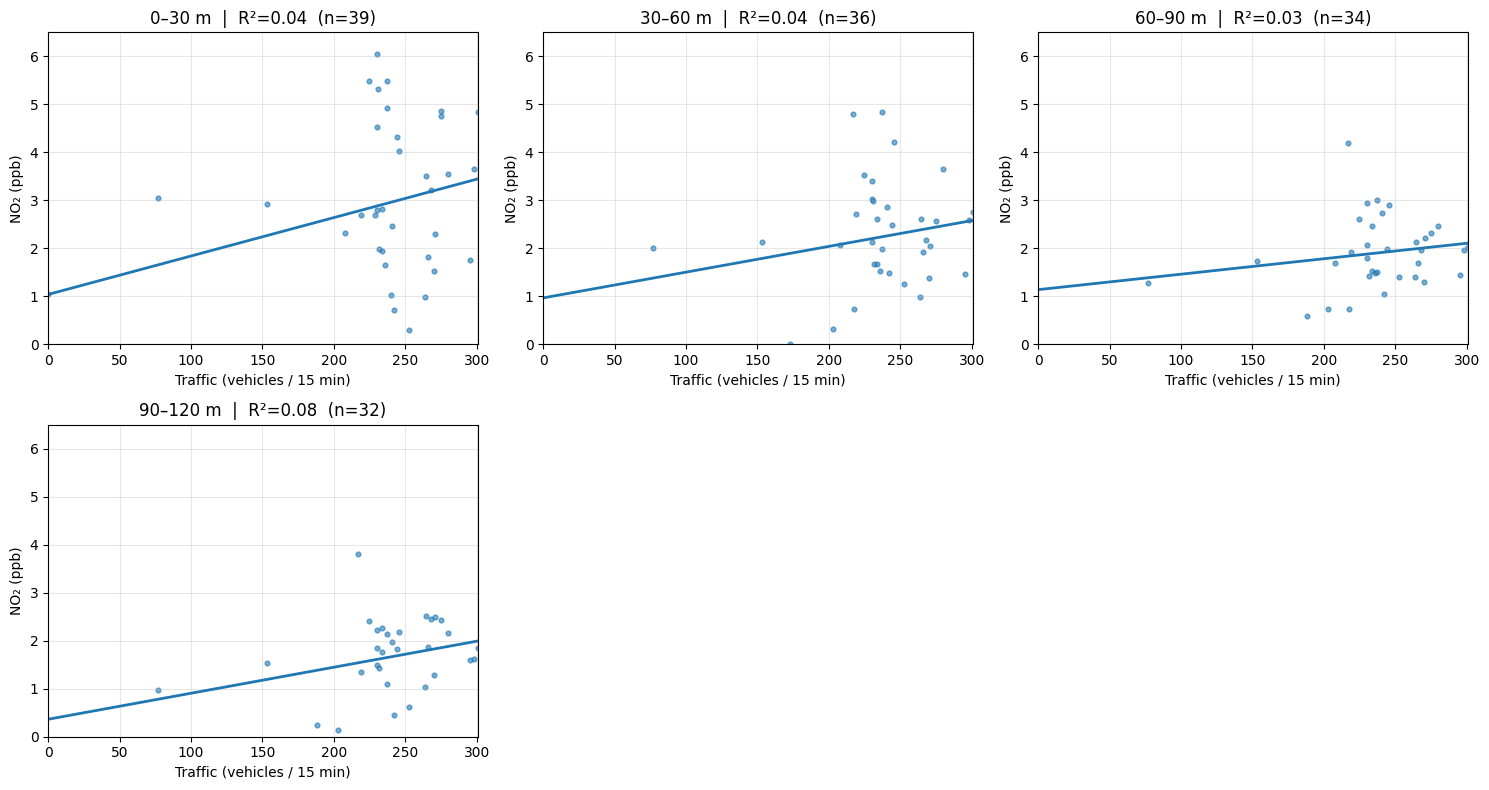

In [92]:
# -----------------------------
# Scatter subplots per bin
# -----------------------------
n = len(stats_df)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
axes = axes.ravel()

# common axes for comparability
x_min = min(lo for lo, hi in xlims)
x_max = max(hi for lo, hi in xlims)
y_min, y_max = 0, 6.5   # force NO₂ range to 0–6.5 ppb

i = 0
for (lo, hi) in [tuple(map(int, r["bin"].split()[0].split("-"))) for _, r in stats_df.iterrows()]:
    ax = axes[i]
    joint = pd.concat([traffic_5.rename("Traffic"),
                       series_per_bin[(lo, hi)].rename("NO2")], axis=1).dropna()

    # limit NO2 to <8 ppb
    joint = joint[joint["NO2"] < 6.5]

    if joint.empty:
        ax.set_title(f"{lo}–{hi} m (no data <6.5 ppb)")
        ax.axis("off")
        i += 1
        continue

    x = joint["Traffic"].values
    y = joint["NO2"].values

    m = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "slope"].values[0]
    b = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "intercept"].values[0]
    r2 = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "R2"].values[0]

    ax.scatter(x, y, s=12, alpha=0.6)
    xx = np.linspace(x_min, x_max, 200)
    ax.plot(xx, m*xx + b, lw=2)

    ax.set_title(f"{lo}–{hi} m  |  R²={r2:.2f}  (n={len(joint)})")
    ax.set_xlabel("Traffic (vehicles / 15 min)")
    ax.set_ylabel("NO₂ (ppb)")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    i += 1

# hide leftover empty axes
for j in range(i, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

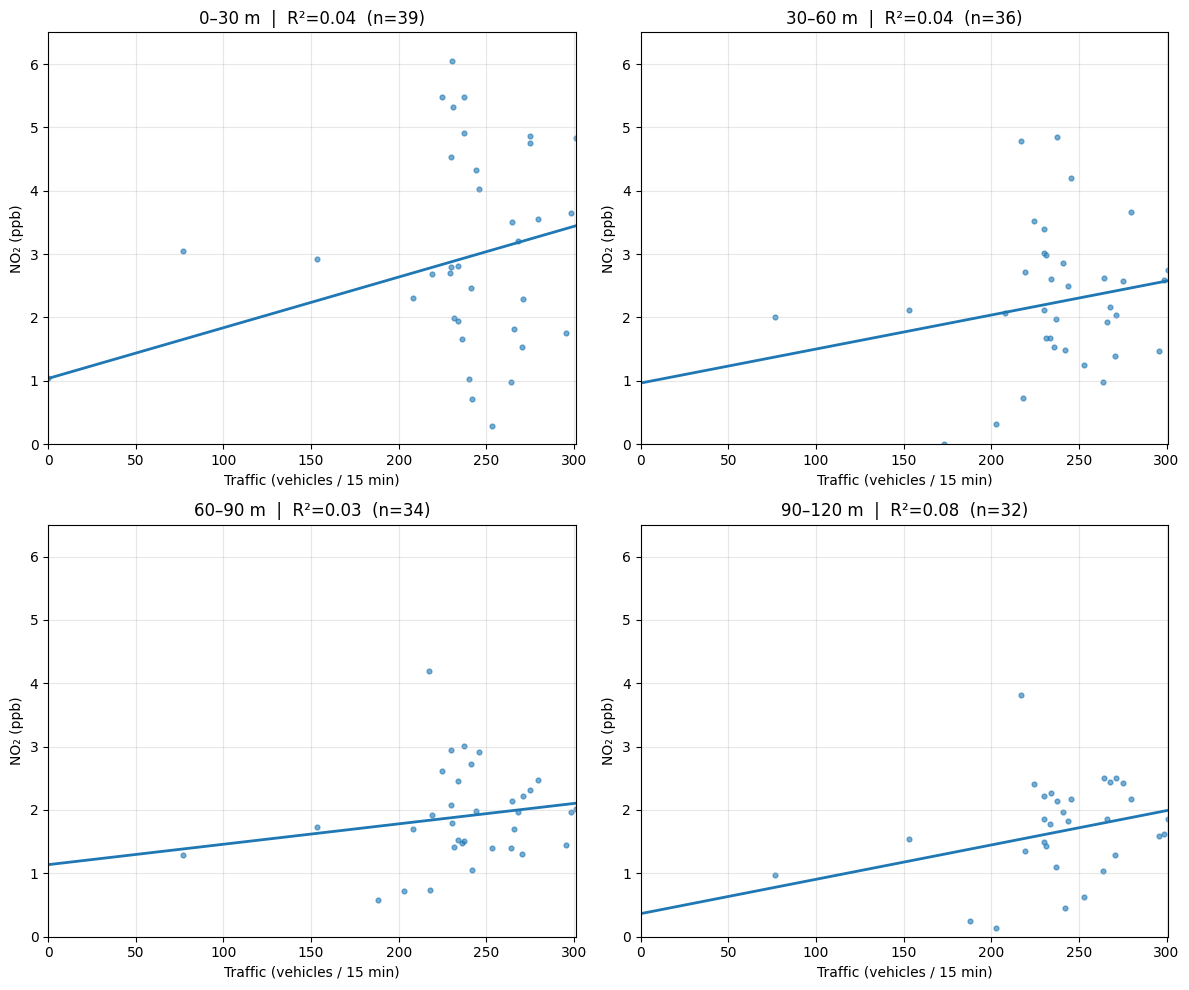

In [99]:
# -----------------------------
# Scatter subplots per bin (2x2 grid)
# -----------------------------
n = len(stats_df)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), squeeze=False)
axes = axes.ravel()

# common axes for comparability
x_min = min(lo for lo, hi in xlims)
x_max = max(hi for lo, hi in xlims)
y_min, y_max = 0, 6.5   # force NO₂ range to 0–6.5 ppb

i = 0
for (lo, hi) in [tuple(map(int, r["bin"].split()[0].split("-"))) for _, r in stats_df.iterrows()]:
    ax = axes[i]
    joint = pd.concat([traffic_5.rename("Traffic"),
                       series_per_bin[(lo, hi)].rename("NO2")], axis=1).dropna()

    # limit NO₂ values
    joint = joint[joint["NO2"] < 6.5]

    if joint.empty:
        ax.set_title(f"{lo}–{hi} m (no data <6.5 ppb)")
        ax.axis("off")
        i += 1
        continue

    x = joint["Traffic"].values
    y = joint["NO2"].values

    # get precomputed regression
    m = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "slope"].values[0]
    b = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "intercept"].values[0]
    r2 = stats_df.loc[stats_df["bin"] == f"{lo}-{hi} m", "R2"].values[0]

    # scatter + regression line
    ax.scatter(x, y, s=12, alpha=0.6)
    xx = np.linspace(x_min, x_max, 200)
    ax.plot(xx, m*xx + b, lw=2)

    ax.set_title(f"{lo}–{hi} m  |  R²={r2:.2f}  (n={len(joint)})")
    ax.set_xlabel("Traffic (vehicles / 15 min)")
    ax.set_ylabel("NO₂ (ppb)")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    i += 1

# hide any unused subplots
for j in range(i, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

 lag_min      bin  n    slope  intercept       R2
      15   0-30 m 39 0.022364  -2.643253 0.181319
      15  30-60 m 36 0.014709  -1.257091 0.223319
      15  60-90 m 34 0.010034  -0.516905 0.209857
      15 90-120 m 32 0.013425  -1.588800 0.325515
      30   0-30 m 39 0.023682  -2.850818 0.289136
      30  30-60 m 36 0.013803  -0.976495 0.275434
      30  60-90 m 34 0.007620   0.111200 0.193355
      30 90-120 m 32 0.010955  -0.907896 0.335518


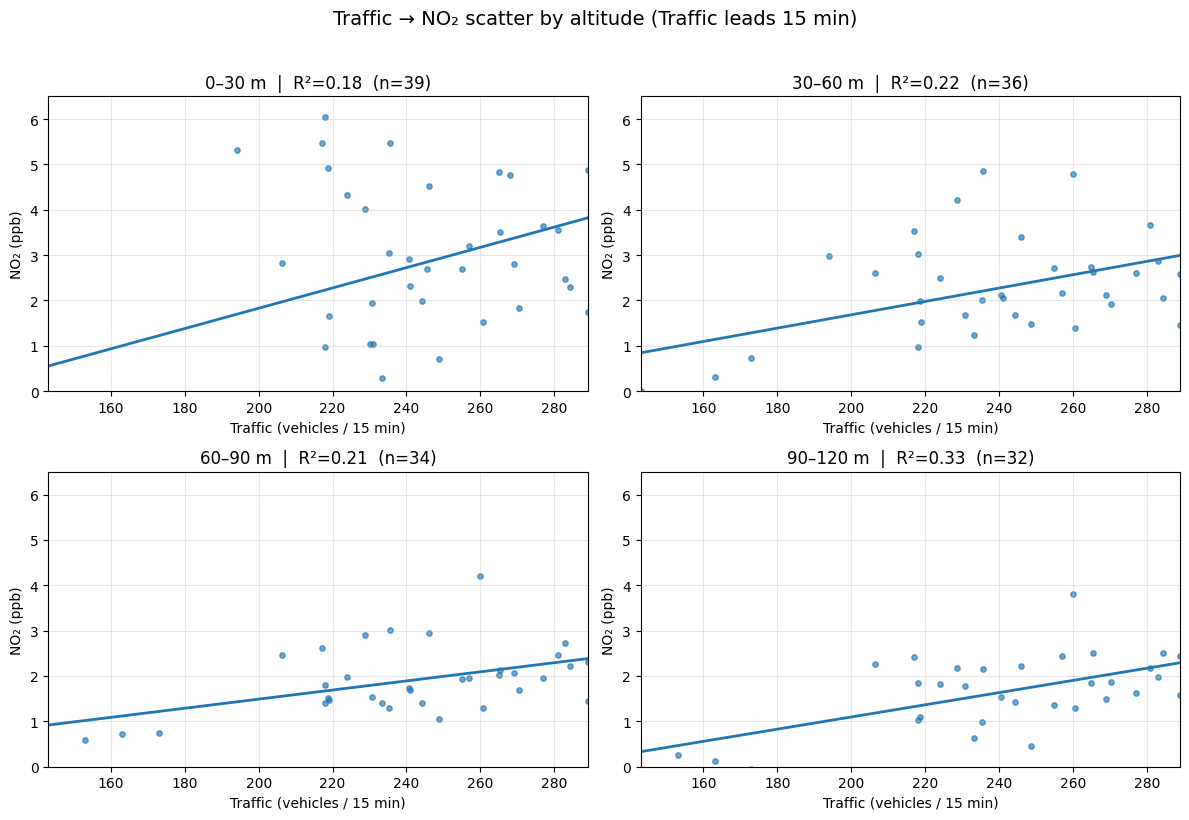

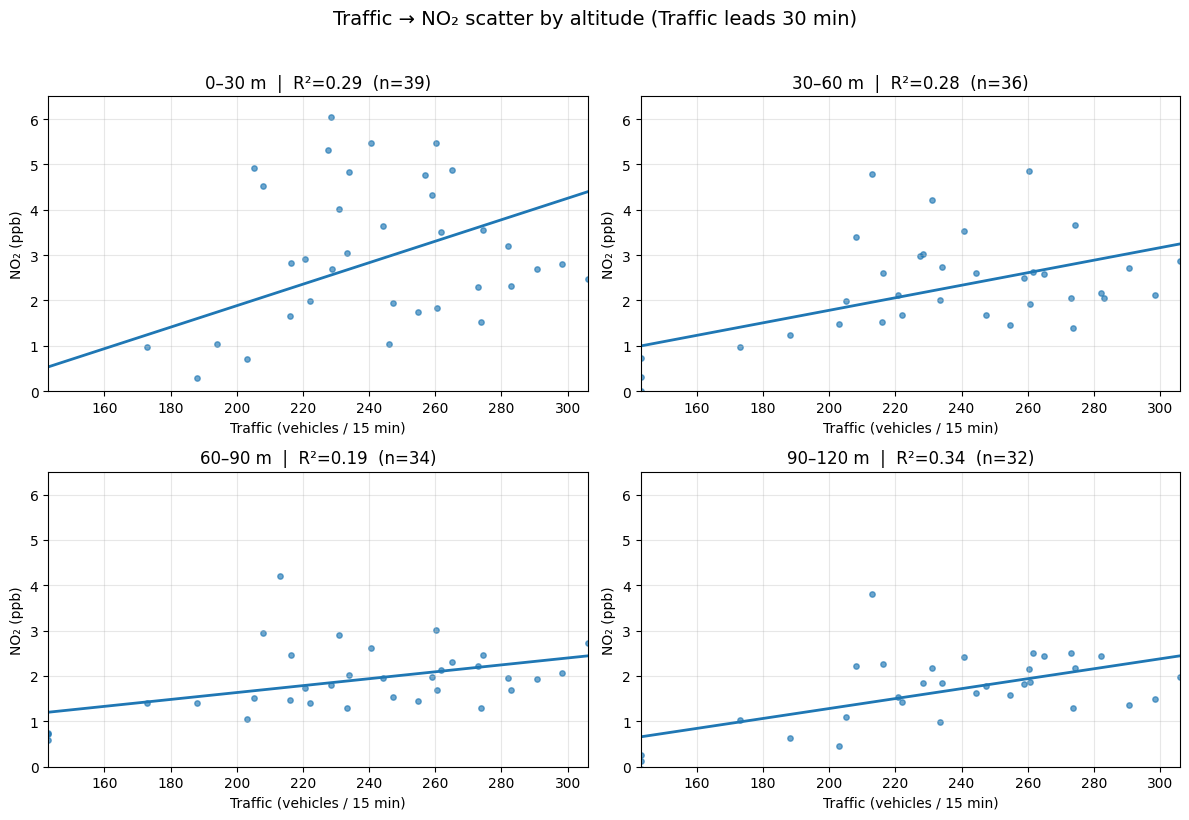

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------
# CONFIG: choose the lag(s) in minutes
# (positive = traffic leads NO2)
# -------------------------------------
LAGS_MIN = [15, 30]          # try 15 or 30
NO2_MAX  = 6.5               # clip for prettier plots (optional)
TIME_BIN = "5min"            # should match how you built series_per_bin / traffic_5

# Assumes you already have:
#  - traffic_5  (Series, local tz, 5-min cadence, vehicles per 5 min)
#  - series_per_bin  (dict: (lo,hi)-> Series of NO2 per 5 min, local tz)
#  - bins (list of (lo,hi) bin tuples)

def fit_for_lag(traffic_5, no2_s, lag_min):
    """
    Align Traffic(t) with NO2(t+lag) by shifting traffic forward.
    Positive lag_min -> traffic leads.
    Returns (joint_df, slope, intercept, r2).
    """
    x = traffic_5.shift(lag_min, freq="min").rename(f"Traffic(+{lag_min}m)")
    y = no2_s.rename("NO2")
    joint = pd.concat([x, y], axis=1).dropna()
    if len(joint) < 3:
        return joint, np.nan, np.nan, np.nan

    xv = joint.iloc[:,0].values
    yv = joint["NO2"].values
    m, b = np.polyfit(xv, yv, 1)
    y_hat = m*xv + b
    ss_res = np.sum((yv - y_hat)**2)
    ss_tot = np.sum((yv - yv.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return joint, m, b, r2

all_rows = []
for lag in LAGS_MIN:
    for (lo, hi), no2_s in series_per_bin.items():
        # optional NO2 clipping
        no2_use = no2_s.copy()
        if NO2_MAX is not None:
            no2_use = no2_use[no2_use < NO2_MAX]

        joint, m, b, r2 = fit_for_lag(traffic_5, no2_use, lag)
        all_rows.append({
            "lag_min": lag,
            "bin": f"{lo}-{hi} m",
            "n": len(joint),
            "slope": m,
            "intercept": b,
            "R2": r2
        })

results_lag = pd.DataFrame(all_rows).sort_values(["lag_min","bin"])
print(results_lag.to_string(index=False))

# -----------------------------
# PLOTS: one 2x2 panel per lag
# -----------------------------
for lag in LAGS_MIN:
    # Prepare common axis ranges (per-lag, across bins)
    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    joints_per_bin = {}
    fits_per_bin = {}

    for (lo, hi), no2_s in series_per_bin.items():
        no2_use = no2_s.copy()
        if NO2_MAX is not None:
            no2_use = no2_use[no2_use < NO2_MAX]
        joint, m, b, r2 = fit_for_lag(traffic_5, no2_use, lag)
        joints_per_bin[(lo,hi)] = (joint, r2)
        fits_per_bin[(lo,hi)] = (m, b)
        if not joint.empty:
            x = joint.iloc[:,0].values
            y = joint["NO2"].values
            xmins.append(np.nanmin(x)); xmaxs.append(np.nanmax(x))
            ymins.append(np.nanmin(y)); ymaxs.append(np.nanmax(y))

    # sensible global axes
    if xmins:
        x_min, x_max = min(xmins), max(xmaxs)
    else:
        x_min, x_max = 0, 1
    if ymins:
        y_min, y_max = 0, max(6.5, max(ymaxs))
    else:
        y_min, y_max = 0, 6.5

    # fixed 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), squeeze=False)
    axes = axes.ravel()

    # ensure consistent bin order
    ordered_bins = [(0,30),(30,60),(60,90),(90,120)]
    for i, (lo, hi) in enumerate(ordered_bins):
        ax = axes[i]
        joint, r2 = joints_per_bin.get((lo,hi), (pd.DataFrame(), np.nan))
        if joint is None or joint.empty:
            ax.set_title(f"{lo}–{hi} m | (no data)")
            ax.axis("off")
            continue

        m, b = fits_per_bin[(lo,hi)]
        x = joint.iloc[:,0].values
        y = joint["NO2"].values

        ax.scatter(x, y, s=15, alpha=0.65)
        xx = np.linspace(x_min, x_max, 200)
        ax.plot(xx, m*xx + b, lw=2)

        ax.set_title(f"{lo}–{hi} m  |  R²={r2:.2f}  (n={len(joint)})")
        ax.set_xlabel("Traffic (vehicles / 15 min)")
        ax.set_ylabel("NO₂ (ppb)")
        ax.grid(True, alpha=0.3)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    fig.suptitle(f"Traffic → NO₂ scatter by altitude (Traffic leads {lag} min)", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()